In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
import os
# /home/zhonghua/data/Dataset_Filted/CosmicRay/QF_CNO_addweight_rho_2.5e13_5.0e17_V3.root
# /home/zhonghua/data/Dataset_Filted/CosmicRay/QF_Fe_addweight_rho_2.5e13_5.0e17_V3.root
# /home/zhonghua/data/Dataset_Filted/CosmicRay/QF_He_addweight_rho_2.5e13_5.0e17_V3.root
# /home/zhonghua/data/Dataset_Filted/CosmicRay/QF_MgAlSi_addweight_rho_2.5e13_5.0e17_V3.root
# /home/zhonghua/data/Dataset_Filted/CosmicRay/QF_Proton_addweight_rho_2.5e13_5.0e17_V3.root
r_cut_low=320
r_cut_high=420
theta_cut_low=10/180*np.pi
theta_cut_high=30/180*np.pi

def open_file(file_name):
    with uproot.open(file_name) as file:
        tree = file["Rec"]
        branches_to_read = ["E", "theta","phi","corex","corey","rec_x","rec_y","rec_theta","rec_phi","rec_Eage","Redge","NpE3","NuM1","NuW2","weightGaisser"]
        df = tree.arrays(branches_to_read, library="pd")
        all_weights = df['weightGaisser'].sum()
        print(file_name)
        print("     Entries:", tree.num_entries)
        print("     Total weights:", all_weights)
        cuts_indices = (df['rec_Eage'] > 0) & (df['Redge'] > 0) & (df['rec_theta'] > theta_cut_low) & (df['rec_theta'] < theta_cut_high)  & (df["NuW2"]>0) & (df["NpE3"]>80)
        df_cut = df[cuts_indices].copy() 
        
        df_cut["R_ue"]=np.log10((1e-4+df_cut["NuM1"])/(df_cut["NpE3"]+1))
        print(f"     Entries after cut: {df_cut.shape[0]}")
        del df
        return df_cut
proton_df = open_file("/home/zhonghua/data/Dataset_Filted/CosmicRay/QF_Proton_addweight_rho_2.5e13_5.0e17_V3.root")
he_df = open_file("/home/zhonghua/data/Dataset_Filted/CosmicRay/QF_He_addweight_rho_2.5e13_5.0e17_V3.root")
cno_df = open_file("/home/zhonghua/data/Dataset_Filted/CosmicRay/QF_CNO_addweight_rho_2.5e13_5.0e17_V3.root")
fe_df = open_file("/home/zhonghua/data/Dataset_Filted/CosmicRay/QF_Fe_addweight_rho_2.5e13_5.0e17_V3.root")
mgalsi_df = open_file("/home/zhonghua/data/Dataset_Filted/CosmicRay/QF_MgAlSi_addweight_rho_2.5e13_5.0e17_V3.root")

# rec E
# /home/zhonghua/data/Dataset_Filted/CosmicRay/energy_correction_xgb_NuW2_8-12.json
from xgboost import XGBRegressor
model = XGBRegressor()
model.load_model("/home/zhonghua/Filt_Event/models/energy_correction_xgb_NuW2_8-12.json")

def energy_correction(df):
    theta=df["rec_theta"].values
    # df["NuW2"]  theta 作为输入
    feature_data = np.column_stack((df["NuW2"].values, theta))
    corrected_energy = model.predict(feature_data)
    df["recE"]=corrected_energy  # log10(TeV)
    return df

proton_df=energy_correction(proton_df)
he_df=energy_correction(he_df)
cno_df=energy_correction(cno_df)
fe_df=energy_correction(fe_df)
mgalsi_df=energy_correction(mgalsi_df)

proton_df["r"]=np.sqrt(proton_df['rec_x']**2+proton_df['rec_y']**2)
he_df["r"]=np.sqrt(he_df['rec_x']**2+he_df['rec_y']**2)
cno_df["r"]=np.sqrt(cno_df['rec_x']**2+cno_df['rec_y']**2)
fe_df["r"]=np.sqrt(fe_df['rec_x']**2+fe_df['rec_y']**2)
mgalsi_df["r"]=np.sqrt(mgalsi_df['rec_x']**2+mgalsi_df['rec_y']**2)

proton_df=proton_df[(proton_df["r"]>r_cut_low) & (proton_df["r"]<r_cut_high)]
he_df=he_df[(he_df["r"]>r_cut_low) & (he_df["r"]<r_cut_high)]
cno_df=cno_df[(cno_df["r"]>r_cut_low) & (cno_df["r"]<r_cut_high)]
fe_df=fe_df[(fe_df["r"]>r_cut_low) & (fe_df["r"]<r_cut_high)]
mgalsi_df=mgalsi_df[(mgalsi_df["r"]>r_cut_low) & (mgalsi_df["r"]<r_cut_high)]

print("经过角度以及半径, 以及NpE NuW2的筛选")


/home/zhonghua/data/Dataset_Filted/CosmicRay/QF_Proton_addweight_rho_2.5e13_5.0e17_V3.root
     Entries: 14217778
     Total weights: 189.58057618423743
     Entries after cut: 5573943
/home/zhonghua/data/Dataset_Filted/CosmicRay/QF_He_addweight_rho_2.5e13_5.0e17_V3.root
     Entries: 14210418
     Total weights: 202.9194024482034
     Entries after cut: 4575126
/home/zhonghua/data/Dataset_Filted/CosmicRay/QF_CNO_addweight_rho_2.5e13_5.0e17_V3.root
     Entries: 14218958
     Total weights: 76.53199899625999
     Entries after cut: 3286951
/home/zhonghua/data/Dataset_Filted/CosmicRay/QF_Fe_addweight_rho_2.5e13_5.0e17_V3.root
     Entries: 14217887
     Total weights: 74.04563549158364
     Entries after cut: 1775344
/home/zhonghua/data/Dataset_Filted/CosmicRay/QF_MgAlSi_addweight_rho_2.5e13_5.0e17_V3.root
     Entries: 14220016
     Total weights: 35.65026967287873
     Entries after cut: 2550528


/home/zhonghua/miniconda3/lib/python3.11/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


经过角度以及半径, 以及NpE NuW2的筛选


In [23]:
189.58057618423743/( 189.58057618423743+202.9194024482034+76.53199899625999+74.04563549158364+35.65026967287873)


0.32758154880882656

In [6]:
import uproot
import numpy as np
file = uproot.open("/home/zhonghua/Filt_Event/model_validation/exposure.root")
h1 = file["h1"]
h2 = file["h2"]
# 获取直方图的所有数据
values = h1.values()        # bin内容（纵坐标）
h2_values = h2.values()        # bin内容（纵坐标）
edges = h1.axis().edges()   # bin边界（横坐标）
h2_edges = h2.axis().edges()   # bin边界（横坐标）
centers = h1.axis().centers()  # bin中心
h2_centers = h2.axis().centers()  # bin中心

values = np.array(h1.values())
edges = np.array(h1.axis().edges())
centers = np.array(h1.axis().centers())
S=np.pi * 1000**2
parker=1e-15 * 1e4 
nums=[]
for i, theta in enumerate(centers):
    cosine_theta = np.cos(np.deg2rad(theta))
    area = S * cosine_theta
    exposure = values[i] * area
    num_i = exposure * parker
    nums.append(num_i)

weights=[num_i/251000/h2_values[i]/86400 for i, num_i in enumerate(nums)]

# 加载磁单极子的数据 /home/zhonghua/data/Dataset_Filted/1e10_V03/Monopole_combined_filted_1e10_V03_dataset.npz
monopole_data=np.load("/home/zhonghua/data/Dataset_Filted/filted_Monopole_1e10_merged_1000_70_new_dataset.npz",allow_pickle=True)
monopole_params=monopole_data["params"]
params_name=monopole_data["param_names"]
monopole_df=pd.DataFrame(monopole_params,columns=params_name)
theta_degrees = monopole_df["rec_theta"] * 180 / np.pi
monopole_weights = []
for theta in theta_degrees:
    if theta > max(centers) or theta < 0:
        weight = weights[-1] if theta > max(centers) else 0
    else:
        bin_id = np.digitize(theta, edges) - 1
        weight = weights[bin_id]
    monopole_weights.append(weight)

monopole_df["weight"] = monopole_weights
print(len(monopole_df["weight"].values),np.sum(monopole_df["weight"].values))
# def plot_show(values, weights, name):
#     plt.hist(values, bins=100, weights=weights, histtype='step',label=name)
#     plt.xlabel(name)
#     plt.ylabel("counts")
#     plt.yscale('log')
#     plt.show()
#     plt.close()
# plot_show(monopole_df["recE"],monopole_df["weight"],"recE")
# plot_show(monopole_df["rec_theta"],monopole_df["weight"],"rec_theta")
# plot_show(monopole_df["r"],monopole_df["weight"],"r")
# plot_show(monopole_df["NpE3"],monopole_df["weight"],"NpE3")
# plot_show(monopole_df["NuW2"],monopole_df["weight"],"NuW2")

# 1e10
log10TeV_low=1.7969200611114502
log10TeV_high=2.1131057739257812
monopole_recx = pd.to_numeric(monopole_df["rec_x"].values, errors='coerce')
monopole_recy = pd.to_numeric(monopole_df["rec_y"].values, errors='coerce')
monopole_df["r"]=np.sqrt(monopole_recx**2+monopole_recy**2)

r_cut_low=320
r_cut_high=420
theta_cut_low=10/180*np.pi
theta_cut_high=30/180*np.pi

monopole_df=monopole_df[(monopole_df["r"]>r_cut_low) & (monopole_df["r"]<r_cut_high) 
                                & (monopole_df["rec_theta"]>theta_cut_low) & (monopole_df["rec_theta"]<theta_cut_high)
                                &(monopole_df["NpE3"]>80) & (monopole_df['NuW2']>0) 
                                ]

print(len(monopole_df["weight"].values),np.sum(monopole_df["weight"].values))
print("经过角度以及半径, 以及NpE NuW2, 以及重建能量的筛选")


104840 3.007714151577215e-05
4627 1.7901916275582354e-06
经过角度以及半径, 以及NpE NuW2, 以及重建能量的筛选


In [ ]:
# 1e10
log10TeV_low=1.7969200611114502
log10TeV_high=2.1131057739257812
ranges = [0.2,3.4]
plt.hist(proton_df["recE"], bins=100, histtype='step',weights=proton_df["weightGaisser"],range=ranges,log=False,label="Proton")
plt.hist(he_df["recE"], bins=100, histtype='step',weights=he_df["weightGaisser"],range=ranges,log=False,label="He")
plt.hist(cno_df["recE"], bins=100, histtype='step',weights=cno_df["weightGaisser"],range=ranges,log=False,label="CNO")
plt.hist(fe_df["recE"], bins=100, histtype='step',weights=fe_df["weightGaisser"],range=ranges,log=False,label="Fe")
plt.hist(mgalsi_df["recE"], bins=100, histtype='step',weights=mgalsi_df["weightGaisser"],range=ranges,log=False,label="MgAlSi")
# 所有加起来
all_recE=np.concatenate([proton_df["recE"],he_df["recE"],cno_df["recE"],fe_df["recE"],mgalsi_df["recE"]])
all_weights=np.concatenate([proton_df["weightGaisser"],he_df["weightGaisser"],cno_df["weightGaisser"],fe_df["weightGaisser"],mgalsi_df["weightGaisser"]])
plt.hist(all_recE, bins=100, histtype='step',weights=all_weights,range=ranges,log=False,label="All")

plt.axvline(x=log10TeV_low, ymax=1, color='r', linestyle='--', label="1e10 energy cut")
plt.axvline(x=log10TeV_high, ymax=1, color='r', linestyle='--')
plt.xlabel("log10(recE / TeV)")
plt.ylabel(r"Rate / Hz") # 单位/s/TeV/sr/cm^2
plt.title("recE distribution with Gaisser Weight")
plt.yscale('log')
plt.legend()
plt.savefig("./figures/recE_distribution_with_Gaisser_Weight.png", dpi=300)
plt.show()


ranges = [1.4,4]
plt.hist(np.log10(proton_df["E"] / 1e3), bins=100, histtype='step',weights=proton_df["weightGaisser"],range=ranges,log=False,label="Proton")
plt.hist(np.log10(he_df["E"] / 1e3), bins=100, histtype='step',weights=he_df["weightGaisser"],range=ranges,log=False,label="He")
plt.hist(np.log10(cno_df["E"] / 1e3), bins=100, histtype='step',weights=cno_df["weightGaisser"],range=ranges,log=False,label="CNO")
plt.hist(np.log10(fe_df["E"] / 1e3), bins=100, histtype='step',weights=fe_df["weightGaisser"],range=ranges,log=False,label="Fe")
plt.hist(np.log10(mgalsi_df["E"] / 1e3), bins=100, histtype='step',weights=mgalsi_df["weightGaisser"],range=ranges,log=False,label="MgAlSi")
# 所有加起来
all_recE=np.concatenate([proton_df["E"],he_df["E"],cno_df["E"],fe_df["E"],mgalsi_df["E"]])
all_weights=np.concatenate([proton_df["weightGaisser"],he_df["weightGaisser"],cno_df["weightGaisser"],fe_df["weightGaisser"],mgalsi_df["weightGaisser"]])
plt.hist(np.log10(all_recE / 1e3), bins=100, histtype='step',weights=all_weights,range=ranges,log=False,label="All")
plt.xlabel("log10(E / TeV)")
plt.ylabel(r"Rate / Hz") # 单位/s/TeV/sr/cm^2
plt.title("E distribution with Gaisser Weight")
plt.yscale('log')
plt.legend()
plt.savefig("./figures/E_distribution_with_Gaisser_Weight.png", dpi=300)
plt.show()

all_E=np.concatenate([proton_df["E"],he_df["E"],cno_df["E"],fe_df["E"],mgalsi_df["E"]])
all_weights=np.concatenate([proton_df["weightGaisser"],he_df["weightGaisser"],cno_df["weightGaisser"],fe_df["weightGaisser"],mgalsi_df["weightGaisser"]])

def sample_ratio(E, weights, particle_name):
    bins_edge=np.logspace(5,6,6)
    hist, bins = np.histogram(E, bins=bins_edge, weights=weights, range=[bins_edge[0], bins_edge[-1]])
    bin_centers = (bins[:-1] + bins[1:]) / 2
    plt.figure(figsize=(8, 6))
    plt.errorbar(bin_centers, hist*np.diff(bins_edge), xerr=np.diff(bins_edge)/2, fmt='o', label=particle_name)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(f"E / TeV\n{hist}")
    plt.legend()
    plt.savefig(f'./figures/sample_ratio/{particle_name}_sample_ratio_1e10.png', dpi=300)
    # plt.show()
    plt.close()
    # hist=hist*np.diff(bins_edge)
    print(f'{particle_name} total weight: {np.sum(hist)}')
    print(f'     sample ratio: {hist/np.sum(hist)}')
    return hist

sample_ratio_proton=sample_ratio(proton_df["E"], proton_df["weightGaisser"], 'Proton')
sample_ratio_he=sample_ratio(he_df["E"], he_df["weightGaisser"], 'He')
sample_ratio_cno=sample_ratio(cno_df["E"], cno_df["weightGaisser"], 'CNO')
sample_ratio_fe=sample_ratio(fe_df["E"], fe_df["weightGaisser"], 'Fe')
sample_ratio_mgalsi=sample_ratio(mgalsi_df["E"], mgalsi_df["weightGaisser"],'MgAlSi')
# E vs recE
from matplotlib.colors import LogNorm


# 假设 log10TeV_low, log10TeV_high 已经定义
# 假设 proton_df 及其列 "E", "recE", "weightGaisser" 已经存在

def plot_E_vs_recE(proton_df, particle_name):
    # --- 定义 Y 轴扫描和百分位数参数 ---
    # 定义 Y 轴的 bin 范围（与 hist2d 的 y 轴范围一致）
    y_min, y_max = 1.5, 3.5
    y_bins = np.linspace(y_min, y_max, 50) # 使用50个 bin进行扫描
    
    # 定义百分位数
    percentiles = [5, 95]
    
    # 转换 E 和 recE 列到 log10(E/TeV) 和 log10(recE/TeV)
    # 注意：您的原始代码中 recE 没有除以 1e3
    logE = np.log10(proton_df["E"] / 1e3) 
    logRecE = proton_df["recE"]
    weights = proton_df["weightGaisser"]

    # 存储每个 Y bin 的 X 轴百分位数
    bin_centers = (y_bins[:-1] + y_bins[1:]) / 2
    x_5th = []
    x_95th = []
    
    # --- Y 轴扫描并计算百分位数 ---
    # --- Y 轴扫描并计算百分位数 ---
    for i in range(len(y_bins) - 1):
        y_low, y_high = y_bins[i], y_bins[i+1]
        
        # 筛选出落在当前 Y 轴 bin 内的数据索引
        mask = (logRecE >= y_low) & (logRecE < y_high)
        
        # 获取筛选后的 X 值和权重
        current_logE = logE[mask]
        current_weights = weights[mask]
        
        if len(current_logE) > 10: 
            # --- 修改开始：转换为 numpy array 以避免索引问题 ---
            
            # 1. 转换为 numpy array (使用 .values)
            vals_logE = current_logE.values 
            vals_weights = current_weights.values
            
            # 2. 排序
            sorted_indices = np.argsort(vals_logE)
            sorted_logE = vals_logE[sorted_indices]
            sorted_weights = vals_weights[sorted_indices]
            
            # 3. 累积求和 (现在得到的是 numpy array)
            cum_weights = np.cumsum(sorted_weights)
            
            # 4. 归一化 (numpy array 支持 [-1] 取最后一位)
            if cum_weights[-1] > 0:
                normalized_cum_weights = cum_weights / cum_weights[-1]
                
                # 5. 插值计算百分位
                p5 = np.interp(percentiles[0] / 100.0, normalized_cum_weights, sorted_logE)
                p95 = np.interp(percentiles[1] / 100.0, normalized_cum_weights, sorted_logE)

                x_5th.append(p5)
                x_95th.append(p95)
            else:
                x_5th.append(np.nan)
                x_95th.append(np.nan)
            # --- 修改结束 ---
            
        else:
            x_5th.append(np.nan)
            x_95th.append(np.nan)

    # 将列表转换为 numpy 数组
    x_5th = np.array(x_5th)
    x_95th = np.array(x_95th)
    
    # --- 绘图部分 ---
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # 2D 直方图 (主图)
    h = ax.hist2d(
        logE, logRecE, 
        bins=100, 
        range=[[1.5, 4.5], [y_min, y_max]], # 确保范围一致
        weights=weights,
        norm=LogNorm()
    )
    
    # 绘制 Y 轴扫描结果
    # 绘制 5% 和 95% 边界
    ax.plot(x_5th, bin_centers, color='b', linestyle='-', linewidth=2, label=f'{percentiles[0]}% Percentile of $\log_{{10}}(\\text{{E}})$')
    ax.plot(x_95th, bin_centers, color='b', linestyle='-', linewidth=2, label=f'{percentiles[1]}% Percentile of $\log_{{10}}(\\text{{E}})$')

    # 可选：绘制中位线 (50%)
    # # x_50th = [np.interp(0.5, normalized_cum_weights, sorted_logE) for ... ]
    # # ax.plot(x_50th, bin_centers, color='white', linestyle='--', linewidth=1, label='Median')
    
    # 绘制对角线 (可选，您的代码中是注释掉的)
    # ax.plot([1.5, 4.5], [1.5, 3.5], color='red', linestyle='--', label="Baseline") 

    # 绘制水平截止线
    ax.axhline(y=log10TeV_low, xmax=1, color='r', linestyle='--', label="1e10 energy cut")
    ax.axhline(y=log10TeV_high, xmax=1, color='r', linestyle='--')
    
    # 颜色条
    plt.colorbar(h[3], ax=ax, label="Rate / $s^{-1} TeV^{-1} sr^{-1} cm^{-2}$") # h[3] 是 QuadMesh 对象

    # 标签和标题
    ax.set_xlabel("log10(E / TeV)")
    ax.set_ylabel("log10(recE / TeV)")
    ax.legend(loc='upper left')
    ax.set_title(f"{particle_name} E vs recE distribution with Gaisser Weight")
    
    plt.savefig(f"./figures/{particle_name}_E_vs_recE_distribution_with_Gaisser_Weight.png", dpi=300)
    plt.show()

# def plot_E_vs_recE(proton_df, particle_name):
#     # 
#     plt.hist2d(np.log10(proton_df["E"]/1e3), proton_df["recE"], bins=100,range=[[1.5,4.5],[1.5,3.5]], weights=proton_df["weightGaisser"],norm=LogNorm())
#     # plt.plot([1.5,4.5],[1.5,3.5],color='r',linestyle='--') # baseline
#     plt.axhline(y=log10TeV_low, xmax=1, color='r', linestyle='--', label="1e10 energy cut")
#     plt.axhline(y=log10TeV_high, xmax=1, color='r', linestyle='--')
#     plt.colorbar(label="Rate / $s^{-1} TeV^{-1} sr^{-1} cm^{-2}$") # 单位/s/TeV/sr/cm^2
#     plt.xlabel("log10(E / TeV)")
#     plt.ylabel("log10(recE / TeV)")
#     plt.legend()
#     plt.title(f"{particle_name} E vs recE distribution with Gaisser Weight")
#     # plt.savefig(f"./figures/{particle_name}_E_vs_recE_distribution_with_Gaisser_Weight.png", dpi=300)
#     plt.show()
# plot_E_vs_recE(proton_df, "Proton")
# plot_E_vs_recE(he_df, "He")
# plot_E_vs_recE(cno_df, "CNO")
# plot_E_vs_recE(fe_df, "Fe")
# plot_E_vs_recE(mgalsi_df, "MgAlSi")


In [7]:
def data_2022():
        # 实验数据
        # /home/zhonghua/data/Dataset_Filted/Experiment/2022/2022_merged_Rue_3.3.root
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        import uproot

        filename = "/home/zhonghua/data/Dataset_Filted/Experiment/2022/2022_merged_Rue_3.3.root"
        file = uproot.open(filename)
        tree = file["ntuple"]
        df_2022 = tree.arrays(library="pd")
        df_2022["weight"]=np.ones(len(df_2022))/365/86400
        df_2022["rec_r"] = np.sqrt(df_2022["r_Corex"]**2 + df_2022["r_Corey"]**2)
        df_2022["R_ue"] = np.log10((df_2022['NuM1']+1e-4)/df_2022['NpE3'])
        print(df_2022.columns)
        age_cut_low=0.8
        age_cut_high=1.2

        recE_cut = 0
        R_ue_cut=-3.3
        df_2022_age_cut=df_2022[(df_2022['age']<age_cut_high) & (df_2022['age']>age_cut_low)]
        df_2022_recE=df_2022_age_cut[df_2022_age_cut["recE"]>recE_cut]
        df_r_cut_recE=df_2022_recE[(df_2022_recE['rec_r']<420) & (df_2022_recE['rec_r']>320) ]
        df_theta_cut=df_r_cut_recE[(df_r_cut_recE['r_Theta']>10/180*np.pi) & (df_r_cut_recE['r_Theta']<30/180*np.pi)]
        df_2022_R_ue_cut_recE = df_theta_cut[df_theta_cut['R_ue']<R_ue_cut]
        df_2022_R_ue_larger_recE = df_theta_cut[df_theta_cut['R_ue']>=R_ue_cut]
        return df_2022_R_ue_cut_recE, df_2022_R_ue_larger_recE
df_2022_R_ue_cut_recE, df_2022_R_ue_larger_recE = data_2022()
print(len(df_2022_R_ue_cut_recE), np.sum(df_2022_R_ue_cut_recE["weight"]))



Index(['mjd', 'r_Theta', 'r_Phi', 'r_Corex', 'r_Corey', 'NhitE', 'NfiltE',
       'NtrigE', 'NhitM', 'NfiltM', 'NpE1', 'NpE2', 'NpE3', 'NuM1', 'NuM2',
       'NuM3', 'size', 'age', 'dr', 'NuW2', 'recE', 'weight', 'rec_r', 'R_ue'],
      dtype='object')
1444 4.5788939624556076e-05


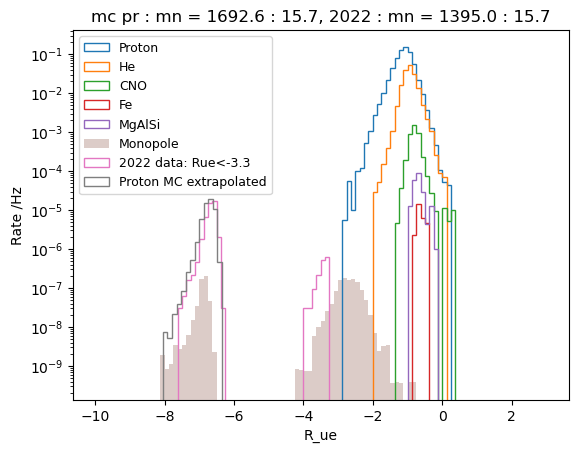

when R_ue<-6, df 2022: 4.423515981735161e-05
proton_df_mu: 1.5308592568158292e-05, ratio: 2.341336268613379e-05
he_df_mu: 0.0, ratio: 0.0
cno_df_mu: 0.0, ratio: 0.0
fe_df_mu: 0.0, ratio: 0.0
mgalsi_df_mu: 0.0, ratio: 0.0
monopole_df_mu: 8.141069055480925e-07, ratio: 0.4801298625191741


In [280]:



def plot_weight_distribution(proton_df, he_df, cno_df, fe_df, mgalsi_df,monopole_df):
    ranges=[-10,2.5]
    R_ue_cut=-3.
    # plt.hist(proton_df["R_ue"], bins=100, histtype='step',weights=proton_df['weightGaisser'],range=ranges, density=False,log=True,label="Proton")
    # plt.hist(he_df["R_ue"], bins=100, histtype='step',weights=he_df['weightGaisser'],range=ranges, density=False,log=True,label="He")
    # plt.hist(cno_df["R_ue"], bins=100, histtype='step',weights=cno_df['weightGaisser'],range=ranges, density=False,log=True,label="CNO")
    # plt.hist(fe_df["R_ue"], bins=100, histtype='step',weights=fe_df['weightGaisser'],range=ranges, density=False,log=True,label="Fe")
    # plt.hist(mgalsi_df["R_ue"], bins=100, histtype='step',weights=mgalsi_df['weightGaisser'],range=ranges, density=False,log=True,label="MgAlSi")
    # plt.hist(monopole_df["R_ue"], bins=100, histtype='stepfilled',alpha=0.3,weights=monopole_df['weight'],range=ranges, density=False,log=True,label="Monopole")
    # plt.axvline(x=R_ue_cut,ymax=1, color='r', linestyle='--', label=f"R_ue cut: {R_ue_cut}")
    # plt.xlabel("R_ue")
    # plt.ylabel(r"Rate /Hz") # 单位/s/TeV/sr/cm^2/ $ TeV^{-1} sr^{-1} cm^{-2}$
    # # plt.yscale('log')
    # plt.legend()
    # plt.title("R_ue distribution with Gaisser Weight")
    # plt.savefig("./figures/R_ue_distribution_with_Gaisser_Weight.png", dpi=300)
    # plt.show()

   
    # ranges = [0.6,2.3]
    # plt.hist(proton_df["rec_Eage"], bins=100, histtype='step', weights=proton_df["weightGaisser"],range=ranges,density=False,log=True,label="Proton")
    # plt.hist(he_df["rec_Eage"], bins=100, histtype='step',weights=he_df["weightGaisser"],range=ranges, density=False,log=True,label="He")
    # plt.hist(cno_df["rec_Eage"], bins=100, histtype='step', weights=cno_df["weightGaisser"],range=ranges,density=False,log=True,label="CNO")
    # plt.hist(fe_df["rec_Eage"], bins=100, histtype='step',weights=fe_df["weightGaisser"] ,range=ranges,density=False,log=True,label="Fe")
    # plt.hist(mgalsi_df["rec_Eage"], bins=100, histtype='step', weights=mgalsi_df["weightGaisser"],range=ranges,density=False,log=True,label="MgAlSi")
    # plt.hist(monopole_df["Eage"], bins=100, histtype='stepfilled',alpha=0.3,weights=monopole_df['weight'],range=ranges, density=False,log=True,label="Monopole")
    # plt.axvline(x=0.8, ymax=1, color='r', linestyle='--')
    # plt.axvline(x=1.2, ymax=1, color='r', linestyle='--')
    # plt.xlabel("Age")
    # plt.ylabel(r"Rate /Hz") # 单位/s/TeV/sr/cm^2  / $ TeV^{-1} sr^{-1} cm^{-2}$
    # plt.title("Shower age distribution")
    # # plt.yscale('log')
    # plt.legend()
    # plt.savefig("./figures/Shower_age_distribution_log.png", dpi=300)
    # plt.show()
    # 类似R_ue 统计
    proton_age_indices =(proton_df["rec_Eage"] > 0.8) & (proton_df["rec_Eage"] < 1.2)
    he_age_indices = (he_df["rec_Eage"] > 0.8) & (he_df["rec_Eage"] < 1.2)
    cno_age_indices = (cno_df["rec_Eage"] > 0.8) & (cno_df["rec_Eage"] < 1.2)
    fe_age_indices = (fe_df["rec_Eage"] > 0.8) & (fe_df["rec_Eage"] < 1.2)
    mgalsi_age_indices = (mgalsi_df["rec_Eage"] > 0.8) & (mgalsi_df["rec_Eage"] < 1.2)
    monopole_age_indices = (monopole_df["Eage"] > 0.8) & (monopole_df["Eage"] < 1.2)
    
   
    # age cut后R_ue的分布
    proton_df_age= proton_df[proton_age_indices]
    he_df_age=he_df[he_age_indices]
    cno_df_age=cno_df[cno_age_indices]
    fe_df_age=fe_df[fe_age_indices]
    mgalsi_df_age=mgalsi_df[mgalsi_age_indices]
    monopole_df_age=monopole_df[monopole_age_indices]
    ranges=[-10,2.5]
    R_ue_cut=-6
    df_2022_num=np.sum(df_2022_R_ue_cut_recE[df_2022_R_ue_cut_recE['R_ue']<R_ue_cut]['weight'])
    monopole_num=np.sum(monopole_df_age[monopole_df_age['R_ue']<R_ue_cut]['weight'])
    proton_extra=scale_weight*np.sum(proton_df_age_new['weightGaisser'])
    time=86400*365
    plt.hist(proton_df_age["R_ue"], bins=100, histtype='step', weights=proton_df_age["weightGaisser"],range=ranges,density=False,log=True,label="Proton")
    plt.hist(he_df_age["R_ue"], bins=100, histtype='step',weights=he_df_age["weightGaisser"],range=ranges, density=False,log=True,label="He")
    plt.hist(cno_df_age["R_ue"], bins=100, histtype='step', weights=cno_df_age["weightGaisser"],range=ranges,density=False,log=True,label="CNO")
    plt.hist(fe_df_age["R_ue"], bins=100, histtype='step',weights=fe_df_age["weightGaisser"] ,range=ranges,density=False,log=True,label="Fe")
    plt.hist(mgalsi_df_age["R_ue"], bins=100, histtype='step', weights=mgalsi_df_age["weightGaisser"],range=ranges,density=False,log=True,label="MgAlSi")
    plt.hist(monopole_df_age["R_ue"], bins=100, histtype='stepfilled',alpha=0.3,weights=monopole_df_age["weight"],range=ranges,density=False,log=True,label="Monopole")
    plt.hist(df_2022_R_ue_cut_recE["R_ue"], bins=100, histtype='step', weights=df_2022_R_ue_cut_recE["weight"],range=ranges,density=False,log=True,label="2022 data: Rue<-3.3")
    plt.hist(proton_df_age_new["R_ue"], bins=100, histtype='step', weights=proton_df_age_new["weightGaisser"]*scale_weight,range=[-10,3],density=False,log=True,label="Proton MC extrapolated")
    
    # plt.axvline(x=R_ue_cut, ymax=1, color='r', linestyle='--', label=f"R_ue cut:{R_ue_cut}")
    plt.xlabel("R_ue")
    plt.ylabel(r"Rate /Hz") # 单位/s/TeV/sr/cm^2  / $ TeV^{-1} sr^{-1} cm^{-2}$
    plt.title(f"mc pr : mn = {proton_extra*time:.1f} : {monopole_num*time:.1f}, 2022 : mn = {df_2022_num*time:.1f} : {monopole_num*time:.1f}")

    # plt.yscale('log')
    plt.legend(fontsize=9)
    plt.savefig("./figures/R_ue_distribution_log_age_cut.png", dpi=300)
    plt.show()
    print(f"when R_ue<-6, df 2022: {np.sum(df_2022_R_ue_cut_recE[df_2022_R_ue_cut_recE['R_ue']<-6]['weight'])}")
    #  # age cut后NuM1的分布
    # ranges=[0,100]
    # plt.hist(proton_df_age["NuM1"], bins=100, histtype='step', weights=proton_df_age["weightGaisser"],range=ranges,density=False,log=True,label="Proton")
    # plt.hist(he_df_age["NuM1"], bins=100, histtype='step',weights=he_df_age["weightGaisser"],range=ranges, density=False,log=True,label="He")
    # plt.hist(cno_df_age["NuM1"], bins=100, histtype='step', weights=cno_df_age["weightGaisser"],range=ranges,density=False,log=True,label="CNO")
    # plt.hist(fe_df_age["NuM1"], bins=100, histtype='step',weights=fe_df_age["weightGaisser"] ,range=ranges,density=False,log=True,label="Fe")
    # plt.hist(mgalsi_df_age["NuM1"], bins=100, histtype='step', weights=mgalsi_df_age["weightGaisser"],range=ranges,density=False,log=True,label="MgAlSi")
    # plt.hist(monopole_df_age["NuM1"], bins=100, histtype='stepfilled',alpha=0.3,weights=monopole_df_age["weight"],range=ranges,density=False,log=True,label="Monopole")
    # plt.xlabel("NuM1")
    # plt.ylabel(r"Rate /Hz") # 单位/s/TeV/sr/cm^2  / $ TeV^{-1} sr^{-1} cm^{-2}$
    # plt.title("NuM1 distribution after age cut")
    # # plt.yscale('linear')
    # plt.legend()
    # # plt.savefig("./figures/NuM1_distribution_log_age_cut.png", dpi=300)
    # plt.show()
    
    # NuM1 ==mu_n_cut
    mu_n_cut=1
    pr_mu_indices=(proton_df_age["NuM1"]<=mu_n_cut)
    he_mu_indices=(he_df_age["NuM1"]<=mu_n_cut)
    cno_mu_indices=(cno_df_age["NuM1"]<=mu_n_cut)
    fe_mu_indices=(fe_df_age["NuM1"]<=mu_n_cut)
    mgalsi_mu_indices=(mgalsi_df_age["NuM1"]<=mu_n_cut)
    monopole_mu_indices=(monopole_df_age["NuM1"]<=mu_n_cut)
    proton_df_mu=proton_df_age[pr_mu_indices]
    he_df_mu=he_df_age[he_mu_indices]
    cno_df_mu=cno_df_age[cno_mu_indices]
    fe_df_mu=fe_df_age[fe_mu_indices]
    mgalsi_df_mu=mgalsi_df_age[mgalsi_mu_indices]
    monopole_df_mu=monopole_df_age[monopole_mu_indices]

    # NuM1 ==0
    print(f"proton_df_mu: {np.sum(proton_df_mu['weightGaisser'])}, ratio: {np.sum(proton_df_mu['weightGaisser'])/np.sum(proton_df_age['weightGaisser'])}")
    print(f"he_df_mu: {np.sum(he_df_mu['weightGaisser'])}, ratio: {np.sum(he_df_mu['weightGaisser'])/np.sum(he_df_age['weightGaisser'])}")
    print(f"cno_df_mu: {np.sum(cno_df_mu['weightGaisser'])}, ratio: {np.sum(cno_df_mu['weightGaisser'])/np.sum(cno_df_age['weightGaisser'])}")
    print(f"fe_df_mu: {np.sum(fe_df_mu['weightGaisser'])}, ratio: {np.sum(fe_df_mu['weightGaisser'])/np.sum(fe_df_age['weightGaisser'])}")
    print(f"mgalsi_df_mu: {np.sum(mgalsi_df_mu['weightGaisser'])}, ratio: {np.sum(mgalsi_df_mu['weightGaisser'])/np.sum(mgalsi_df_age['weightGaisser'])}")
    print(f"monopole_df_mu: {np.sum(monopole_df_mu['weight'])}, ratio: {np.sum(monopole_df_mu['weight'])/np.sum(monopole_df_age['weight'])}")

    return proton_df_age

log10TeV_low=1.7969200611114502
log10TeV_high=2.1131057739257812
proton_df_E = proton_df[(proton_df["recE"]>log10TeV_low) & (proton_df["recE"]<log10TeV_high)]
he_df_E = he_df[(he_df["recE"]>log10TeV_low) & (he_df["recE"]<log10TeV_high)]
cno_df_E = cno_df[(cno_df["recE"]>log10TeV_low) & (cno_df["recE"]<log10TeV_high)]
fe_df_E = fe_df[(fe_df["recE"]>log10TeV_low) & (fe_df["recE"]<log10TeV_high)]
mgalsi_df_E = mgalsi_df[(mgalsi_df["recE"]>log10TeV_low) & (mgalsi_df["recE"]<log10TeV_high)]
monopole_df_E = monopole_df[(monopole_df["recE"]>log10TeV_low) & (monopole_df["recE"]<log10TeV_high)]


proton_df_age = plot_weight_distribution(proton_df_E, he_df_E, cno_df_E, fe_df_E, mgalsi_df_E, monopole_df_E)


拟合参数: Amp=6.45e-01, MPV=33.44, Width=12.27
直接取函数值 f(0):       3.9968e-05 (不推荐)
积分区间 [0, 1] 的 Rate: 5.3673e-05 Hz (推荐)


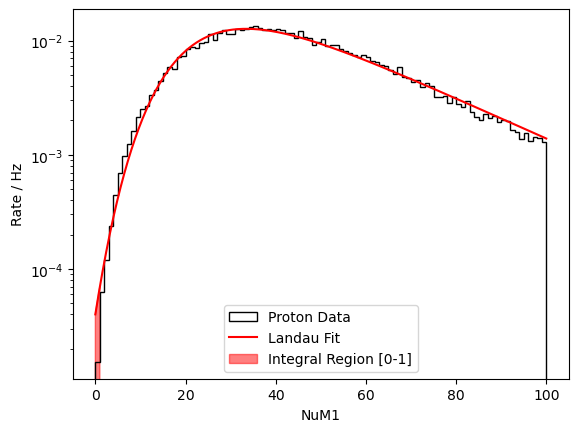

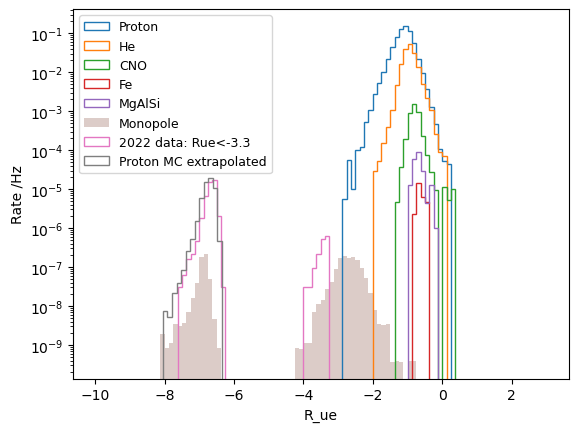

when R_ue<-6, df 2022: 4.423515981735161e-05
proton_df_mu: 1.5308592568158292e-05, ratio: 2.341336268613379e-05
he_df_mu: 0.0, ratio: 0.0
cno_df_mu: 0.0, ratio: 0.0
fe_df_mu: 0.0, ratio: 0.0
mgalsi_df_mu: 0.0, ratio: 0.0
monopole_df_mu: 8.543220908936446e-07, ratio: 0.47992779663936824


In [274]:
def NuM1_fit(proton_df_age_infit):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.optimize import curve_fit
    from scipy.special import gammaln # <--- 关键引入：对数伽马函数

    # ==========================================
    # 1. 准备直方图数据
    # ==========================================
    ranges = [0, 300]
    bins = 300  # 保持细致的 binning

    hist_y, bin_edges = np.histogram(
        proton_df_age_infit["NuM1"], 
        bins=bins, 
        range=ranges, 
        weights=proton_df_age_infit["weightGaisser"]
    )

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # 过滤数据：只拟合有计数的部分，且为了稳定性，建议由峰值附近开始
    mask = hist_y > 0
    x_fit = bin_centers[mask]
    y_fit = hist_y[mask]
    
    # 误差估计
    sigma_fit = np.sqrt(y_fit) 
    # 防止 sigma 为 0 (如果权重很小可能发生)，给一个极小值作为下限
    sigma_fit[sigma_fit == 0] = 1e-10

    # ==========================================
    # 2. 定义拟合函数 (数值稳定版 Poisson)
    # ==========================================
    def poisson_log_stable(k, lamb, scale):
        """
        在对数空间计算 Poisson，防止 overflow。
        y = scale * (lamb^k * e^-lamb) / k!
        ln(y) = ln(scale) + k*ln(lamb) - lamb - gammaln(k+1)
        """
        # 防止 log(0) 或 log(负数)
        if lamb <= 0: 
            return np.zeros_like(k)
        
        # 计算对数部分
        log_y = np.log(scale) + k * np.log(lamb) - lamb - gammaln(k + 1)
        
        # 返回指数部分
        return np.exp(log_y)

    # ==========================================
    # 3. 执行拟合
    # ==========================================
    # 优化初始猜测 (p0)
    # Mean 容易受长尾影响，用 Mode (峰值位置) 猜测 Lambda 会更准
    peak_index = np.argmax(y_fit)
    guess_lambda = x_fit[peak_index] # 看起来大概是 40 左右
    guess_scale = np.max(y_fit)      # 看起来大概是 0.013 左右

    p0 = [guess_lambda, guess_scale]
    
    # 设置边界 bounds: Lambda 必须 > 0, Scale 必须 > 0
    bounds = ([0.001, 0], [np.inf, np.inf])

    try:
        popt, pcov = curve_fit(
            poisson_log_stable, 
            x_fit, 
            y_fit, 
            p0=p0, 
            sigma=sigma_fit, 
            absolute_sigma=True,
            bounds=bounds
        )
        fit_lambda, fit_scale = popt
        fit_success = True
        print(f"拟合成功: Lambda (Mean) = {fit_lambda:.4f}, Scale = {fit_scale:.4e}")
    except Exception as e:
        fit_success = False
        print(f"拟合失败: {e}")
        popt = [0, 0]

    # ==========================================
    # 4. 计算关注区域 (NuM1 = 0) 的值
    # ==========================================
    if fit_success:
        # 代入 x=0 计算
        rate_at_zero = poisson_log_stable(0, *popt)
    else:
        rate_at_zero = 0

    print(f"========================================")
    print(f"推断 NuM1=0 处的 Rate: {rate_at_zero:.4e} Hz")
    print(f"========================================")

    # ==========================================
    # 5. 绘图
    # ==========================================
    # plt.figure(figsize=(10, 7)) # 如果在函数外创建了 figure，这里可以注释掉
    
    plt.hist(
        proton_df_age_infit["NuM1"], 
        bins=bins, 
        range=ranges,
        histtype='step', 
        weights=proton_df_age_infit["weightGaisser"],
        color='black',
        linewidth=1.5,
        label="Proton Data"
    )

    if fit_success:
        x_plot = np.linspace(0, 300, 1000)
        y_plot = poisson_log_stable(x_plot, *popt)
        
        plt.plot(x_plot, y_plot, 'r--', linewidth=2, label=f'Poisson Fit ($\lambda$={fit_lambda:.1f})')
        
        plt.scatter([0], [rate_at_zero], color='red', s=150, marker='*', zorder=10, 
                   label=f'Extrap @0: {rate_at_zero:.2e} Hz')

    plt.xlabel("NuM1")
    plt.ylabel("Rate / Hz")
    plt.title("Proton NuM1 Distribution (Log-Stable Fit)")
    plt.legend()
    # plt.yscale('log') # 建议开启 log 来看 0 处的量级，如果 0 处非常小的话
    plt.grid(True, alpha=0.2)
    plt.show()

def NuM1_fit_landau_integrated(proton_df_age_infit, bins=300, ranges=[0, 300]):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.optimize import curve_fit
    from scipy.stats import moyal
    from scipy.integrate import quad # <--- 引入积分函数

   
    hist_y, bin_edges = np.histogram(
        proton_df_age_infit["NuM1"], 
        bins=bins, 
        range=ranges, 
        weights=proton_df_age_infit["weightGaisser"]
    )
    
    # 算出 bin 宽度
    bin_width = (ranges[1] - ranges[0]) / bins
    
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # 筛选拟合数据
    mask = hist_y > 0
    x_fit = bin_centers[mask]
    y_fit = hist_y[mask]
    sigma_fit = np.sqrt(y_fit)
    sigma_fit[sigma_fit == 0] = 1e-10

    # 2. 定义函数 (Moyal/Landau)
    # 注意：这里的 amplitude 实际上是“总面积”的一个缩放因子，因为 pdf 积分是 1
    # 如果 hist_y 是 Rate，那么 amplitude 大概就是总 Rate
    def landau_func(x, amplitude, mpv, width):
        return amplitude * moyal.pdf(x, loc=mpv, scale=width)

    # 3. 拟合
    # 改进初始猜测
    p0 = [np.sum(y_fit)*bin_width, x_fit[np.argmax(y_fit)], 10.0] 
    bounds = ([0, 0, 0.1], [np.inf, 300, 100])

    try:
        popt, pcov = curve_fit(landau_func, x_fit, y_fit, p0=p0, sigma=sigma_fit, absolute_sigma=True, bounds=bounds)
        fit_success = True
        print(f"拟合参数: Amp={popt[0]:.2e}, MPV={popt[1]:.2f}, Width={popt[2]:.2f}")
    except Exception as e:
        print(f"拟合失败: {e}")
        fit_success = False
        popt = [0, 0, 0]

    # ======================================================
    # 4. 关键步骤：积分计算 NuM1 在 [0, 1] 区间的 Rate
    # ======================================================
    if fit_success:
        # 定义被积函数 (即我们拟合出来的函数)
        def fitted_curve(x):
            return landau_func(x, *popt)
        
        # 对 0 到 1 进行积分
        # 这里的 1 实际上是 bin_width。如果你的第一格是 0-1，就积 0-1。
        rate_integrated, error = quad(fitted_curve, 0, 1)
        
        print(f"========================================")
        print(f"直接取函数值 f(0):       {fitted_curve(0):.4e} (不推荐)")
        print(f"积分区间 [0, 1] 的 Rate: {rate_integrated:.4e} Hz (推荐)")
        print(f"========================================")
    else:
        rate_integrated = 0

    # 5. 绘图
    plt.hist(proton_df_age_infit["NuM1"], bins=bins, range=ranges,
             histtype='step', weights=proton_df_age_infit["weightGaisser"],
             label="Proton Data", color='black')

    if fit_success:
        x_plot = np.linspace(ranges[0],ranges[1], 1000)
        plt.plot(x_plot, landau_func(x_plot, *popt), 'r-', label="Landau Fit")
        
        # 画出我们积分的那个小区域 (0-1)
        x_area = np.linspace(0, 1, 50)
        plt.fill_between(x_area, landau_func(x_area, *popt), color='red', alpha=0.5, label="Integral Region [0-1]")

    plt.xlabel("NuM1")
    plt.ylabel("Rate / Hz")
    plt.legend()
    plt.yscale('log') # 推荐打开 log 看 0 处的细节
    plt.show()
    return rate_integrated
# 模拟调用
# NuM1_fit_landau_integrated(proton_df_age)
# 调用函数 (请确保传入了您的 DataFrame)
# NuM1_fit_landau(proton_df_age)
# NuM1_fit(proton_df_age)

proton_df_age_cp=proton_df_age.copy()
# NuM1_fit(proton_df_age_infit=proton_df_age_cp_mu3)
rate_integrated=NuM1_fit_landau_integrated(proton_df_age_infit=proton_df_age, ranges=[0,100], bins=100)
proton_df_age_new=proton_df_age.copy()
proton_df_age_new["NuM1"]=0
sum_weight_pr=np.sum(proton_df_age_new["weightGaisser"])
scale_weight=rate_integrated/sum_weight_pr
proton_df_age_new["R_ue"]=np.log10((proton_df_age_new["NuM1"]+1e-4)/proton_df_age_new["NpE3"])

proton_df_age = plot_weight_distribution(proton_df_E, he_df_E, cno_df_E, fe_df_E, mgalsi_df_E, monopole_df)





In [ ]:
print(f"when 1.8 < log10(recE) < 2.1:")
print(f"Proton: {np.sum(proton_df_E['weightGaisser'])}, left ratio: {np.sum(proton_df_E['weightGaisser'])/np.sum(proton_df['weightGaisser'])}")
print(f"He: {np.sum(he_df_E['weightGaisser'])}, left ratio: {np.sum(he_df_E['weightGaisser'])/np.sum(he_df['weightGaisser'])}")
print(f"CNO: {np.sum(cno_df_E['weightGaisser'])}, left ratio: {np.sum(cno_df_E['weightGaisser'])/np.sum(cno_df['weightGaisser'])}")
print(f"Fe: {np.sum(fe_df_E['weightGaisser'])}, left ratio: {np.sum(fe_df_E['weightGaisser'])/np.sum(fe_df['weightGaisser'])}")
print(f"MgAlSi: {np.sum(mgalsi_df_E['weightGaisser'])}, left ratio: {np.sum(mgalsi_df_E['weightGaisser'])/np.sum(mgalsi_df['weightGaisser'])}")
print(f"Proton:He:CNO:Fe:MgAlSi={np.sum(proton_df_E['weightGaisser']):2e}:{np.sum(he_df_E['weightGaisser']):2e}:{np.sum(cno_df_E['weightGaisser']):2e}:{np.sum(fe_df_E['weightGaisser']):2e}:{np.sum(mgalsi_df_E['weightGaisser']):2e}")
print(f"Monopole: {np.sum(monopole_df_E['weight'])}, left ratio: {np.sum(monopole_df_E['weight'])/np.sum(monopole_df['weight'])}")
print()
proton_df_age=proton_df_E[(proton_df_E["rec_Eage"] > 0.8) & (proton_df_E["rec_Eage"] < 1.2)]
he_df_age=he_df_E[(he_df_E["rec_Eage"] > 0.8) & (he_df_E["rec_Eage"] < 1.2)]
cno_df_age=cno_df_E[(cno_df_E["rec_Eage"] > 0.8) & (cno_df_E["rec_Eage"] < 1.2)]
fe_df_age=fe_df_E[(fe_df_E["rec_Eage"] > 0.8) & (fe_df_E["rec_Eage"] < 1.2)]
mgalsi_df_age=mgalsi_df_E[(mgalsi_df_E["rec_Eage"] > 0.8) & (mgalsi_df_E["rec_Eage"] < 1.2)]
monopole_df_age=monopole_df_E[(monopole_df_E["Eage"] > 0.8) & (monopole_df_E["Eage"] < 1.2)]
print(f"when 0.8 < age < 1.2:")
print(f"Proton: {np.sum(proton_df_age['weightGaisser'])}, left ratio: {np.sum(proton_df_age['weightGaisser'])/np.sum(proton_df_E['weightGaisser'])}")
print(f"He: {np.sum(he_df_age['weightGaisser'])}, left ratio: {np.sum(he_df_age['weightGaisser'])/np.sum(he_df_E['weightGaisser'])}")
print(f"CNO: {np.sum(cno_df_age['weightGaisser'])}, left ratio: {np.sum(cno_df_age['weightGaisser'])/np.sum(cno_df_E['weightGaisser'])}")
print(f"Fe: {np.sum(fe_df_age['weightGaisser'])}, left ratio: {np.sum(fe_df_age['weightGaisser'])/np.sum(fe_df_E['weightGaisser'])}")
print(f"MgAlSi: {np.sum(mgalsi_df_age['weightGaisser'])}, left ratio: {np.sum(mgalsi_df_age['weightGaisser'])/np.sum(mgalsi_df_E['weightGaisser'])}")
print(f"Proton:He:CNO:Fe:MgAlSi={np.sum(proton_df_age['weightGaisser']):2e}:{np.sum(he_df_age['weightGaisser']):2e}:{np.sum(cno_df_age['weightGaisser']):2e}:{np.sum(fe_df_age['weightGaisser']):2e}:{np.sum(mgalsi_df_age['weightGaisser']):2e}")
print(f"Monopole: {np.sum(monopole_df_age['weight'])}, left ratio: {np.sum(monopole_df_age['weight'])/np.sum(monopole_df_E['weight'])}")
print()
R_ue_cut=-3
proton_df_Rue_age=proton_df_age[(proton_df_age['R_ue']<R_ue_cut)]
he_df_Rue_age=he_df_age[(he_df_age['R_ue']<R_ue_cut)]
cno_df_Rue_age=cno_df_age[(cno_df_age['R_ue']<R_ue_cut)]
fe_df_Rue_age=fe_df_age[(fe_df_age['R_ue']<R_ue_cut)]
mgalsi_df_Rue_age=mgalsi_df_age[(mgalsi_df_age['R_ue']<R_ue_cut)]
monopole_df_Rue_age=monopole_df_age[(monopole_df_age['R_ue']<R_ue_cut)]

print(f"after age cut: when R_ue < {R_ue_cut}:")
print(f"Proton: {np.sum(proton_df_Rue_age['weightGaisser'])}, left ratio: {np.sum(proton_df_Rue_age['weightGaisser'])/np.sum(proton_df_age['weightGaisser'])}")
print(f"He: {np.sum(he_df_Rue_age['weightGaisser'])}, left ratio: {np.sum(he_df_Rue_age['weightGaisser'])/np.sum(he_df_age['weightGaisser'])}")
print(f"CNO: {np.sum(cno_df_Rue_age['weightGaisser'])}, left ratio: {np.sum(cno_df_Rue_age['weightGaisser'])/np.sum(cno_df_age['weightGaisser'])}")
print(f"Fe: {np.sum(fe_df_Rue_age['weightGaisser'])}, left ratio: {np.sum(fe_df_Rue_age['weightGaisser'])/np.sum(fe_df_age['weightGaisser'])}")
print(f"MgAlSi: {np.sum(mgalsi_df_Rue_age['weightGaisser'])}, left ratio: {np.sum(mgalsi_df_Rue_age['weightGaisser'])/np.sum(mgalsi_df_age['weightGaisser'])}")
print(f"Proton:He:CNO:Fe:MgAlSi={np.sum(proton_df_Rue_age['weightGaisser']):2e}:{np.sum(he_df_Rue_age['weightGaisser']):2e}:{np.sum(cno_df_Rue_age['weightGaisser']):2e}:{np.sum(fe_df_Rue_age['weightGaisser']):2e}:{np.sum(mgalsi_df_Rue_age['weightGaisser']):2e}")
print(f"Monopole: {np.sum(monopole_df_Rue_age['weight'])}, left ratio: {np.sum(monopole_df_Rue_age['weight'])/np.sum(monopole_df_age['weight'])}")
cosmic_ray=np.sum(proton_df_Rue_age['weightGaisser'])+np.sum(he_df_Rue_age['weightGaisser'])+np.sum(cno_df_Rue_age['weightGaisser'])+np.sum(fe_df_Rue_age['weightGaisser'])+np.sum(mgalsi_df_Rue_age['weightGaisser'])
monopole_ray=np.sum(monopole_df_Rue_age['weight'])
print(f"Cosmic Ray : Monopole = {cosmic_ray/monopole_ray:.2f} : 1")
print(f"one day: Proton={np.sum(proton_df_Rue_age['weightGaisser'])*86400}, Monopole={np.sum(monopole_df_Rue_age['weight'])*86400}")
print(f"one year: Proton={np.sum(proton_df_Rue_age['weightGaisser'])*86400*365}, Monopole={np.sum(monopole_df_Rue_age['weight'])*86400*365}")
print()
print(f"Event Number in MC data:")
print(f"Proton: recE cut={len(proton_df_E)}, age cut={len(proton_df_age)}, R_ue cut={len(proton_df_Rue_age)}")
print(f"He: recE cut={len(he_df_E)}, age cut={len(he_df_age)}, R_ue cut={len(he_df_Rue_age)}")
print(f"CNO: recE cut={len(cno_df_E)}, age cut={len(cno_df_age)}, R_ue cut={len(cno_df_Rue_age)}")
print(f"Fe: recE cut={len(fe_df_E)}, age cut={len(fe_df_age)}, R_ue cut={len(fe_df_Rue_age)}")
print(f"MgAlSi: recE cut={len(mgalsi_df_E)}, age cut={len(mgalsi_df_age)}, R_ue cut={len(mgalsi_df_Rue_age)}")
print(f"Monopole: recE cut={len(monopole_df_E)}, age cut={len(monopole_df_age)}, R_ue cut={len(monopole_df_Rue_age)}")



when 1.8 < log10(recE) < 2.1:
Proton: 2.2189283557469808, left ratio: 0.09652492772251174
He: 1.945147633852749, left ratio: 0.10950744285495137
CNO: 0.48427836865534446, left ratio: 0.11942830886744478
Fe: 0.2819229399081261, left ratio: 0.13326090502135934
MgAlSi: 0.1770826897510368, left ratio: 0.1259254796573671
Proton:He:CNO:Fe:MgAlSi=2.218928e+00:1.945148e+00:4.842784e-01:2.819229e-01:1.770827e-01
Monopole: 1.7041509457348718e-06, left ratio: 0.9519377252698247

when 0.8 < age < 1.2:
Proton: 0.6538399790485703, left ratio: 0.29466475443208323
He: 0.16980885559754996, left ratio: 0.08729869786860857
CNO: 0.0039535429966731945, left ratio: 0.008163781933210582
Fe: 2.7762891232194252e-05, left ratio: 9.847687896998273e-05
MgAlSi: 0.00021135679426874333, left ratio: 0.00119354858775803
Proton:He:CNO:Fe:MgAlSi=6.538400e-01:1.698089e-01:3.953543e-03:2.776289e-05:2.113568e-04
Monopole: 1.695597314602736e-06, left ratio: 0.9949807080449395

after age cut: when R_ue < -3:
Proton: 0.0, lef

In [1]:
# 分析实验数据异常
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uproot
MC_data = np.load("/home/zhonghua/data/Dataset_Filted/CosmicRay/Npz/Proton_1000_70_1e10_V03_dataset.npz", allow_pickle=True)
MC_params = MC_data["params"]
MC_params = np.array(MC_params, dtype=float)
param_names=MC_data["param_names"]
print(param_names)
rootfile = "/home/zhonghua/Filt_Event/model_validation/exposure.root"
with uproot.open(rootfile) as f:
    hWeight = f["hWeight"]
    edges_E = hWeight.axes[0].edges()  # Energy bin edges
    edges_Zen = hWeight.axes[1].edges()  # Zenith bin edges
    weights_2d = hWeight.values()

def add_weights(trueE, rec_zenith, weights_2d):
    trueE=np.log10(trueE/1e3)
    rec_zenith=180/np.pi*rec_zenith
    bin_idx_E = np.digitize(trueE, edges_E) - 1
    bin_idx_Zen = np.digitize(rec_zenith, edges_Zen) - 1
    return weights_2d[bin_idx_E, bin_idx_Zen]


r_cut_low=300
r_cut_high=500
theta_cut_high=50
theta_cut_low=0

pr_params=np.array(MC_params,dtype=float)
pr_df=pd.DataFrame(pr_params,columns=param_names)
pr_df["r"]=np.sqrt(pr_df["rec_x"]**2+pr_df["rec_y"]**2)
pr_df=pr_df[(pr_df["r"]<r_cut_high) & (pr_df["r"]>r_cut_low) & (pr_df["rec_theta"]<theta_cut_high) & (pr_df["rec_theta"]>theta_cut_low)]
pr_df['weight']=pr_df.apply(lambda row: add_weights(row['trueE'],row['rec_theta'],weights_2d),axis=1)
pr_df["weight"]=pr_df["weight"]/86400*0.1*0.43
print("proton",np.sum(pr_df['weight']))

import numpy as np
file = uproot.open("/home/zhonghua/Filt_Event/model_validation/exposure.root")
h1 = file["h1"]
h2 = file["h2"]
# 获取直方图的所有数据
values = h1.values()        # bin内容（纵坐标）
h2_values = h2.values()        # bin内容（纵坐标）
edges = h1.axis().edges()   # bin边界（横坐标）
h2_edges = h2.axis().edges()   # bin边界（横坐标）
centers = h1.axis().centers()  # bin中心
h2_centers = h2.axis().centers()  # bin中心

values = np.array(h1.values())
edges = np.array(h1.axis().edges())
centers = np.array(h1.axis().centers())
S=np.pi * 1000**2
parker=1e-15 * 1e4 
nums=[]
for i, theta in enumerate(centers):
    cosine_theta = np.cos(np.deg2rad(theta))
    area = S * cosine_theta
    exposure = values[i] * area
    num_i = exposure * parker
    nums.append(num_i)

weights=[num_i/251000/h2_values[i]/86400 for i, num_i in enumerate(nums)]

# 加载磁单极子的数据 /home/zhonghua/data/Dataset_Filted/1e10_V03/Monopole_combined_filted_1e10_V03_dataset.npz
monopole_data=np.load("/home/zhonghua/data/Dataset_Filted/filted_Monopole_1e10_merged_1000_70_new_dataset.npz",allow_pickle=True)
monopole_params=monopole_data["params"]
params_name=monopole_data["param_names"]
monopole_df=pd.DataFrame(monopole_params,columns=params_name)
theta_degrees = monopole_df["rec_theta"] * 180 / np.pi
monopole_weights = []
for theta in theta_degrees:
    if theta > max(centers) or theta < 0:
        weight = weights[-1] if theta > max(centers) else 0
    else:
        bin_id = np.digitize(theta, edges) - 1
        weight = weights[bin_id]
    monopole_weights.append(weight)

monopole_df["weight"] = monopole_weights
print("mn",len(monopole_df["weight"].values),np.sum(monopole_df["weight"].values))

# 1e10
monopole_recx = pd.to_numeric(monopole_df["rec_x"].values, errors='coerce')
monopole_recy = pd.to_numeric(monopole_df["rec_y"].values, errors='coerce')
monopole_df["r"]=np.sqrt(monopole_recx**2+monopole_recy**2)
mn_df=monopole_df[(monopole_df["r"]>r_cut_low) & (monopole_df["r"]<r_cut_high) 
                                & (monopole_df["rec_theta"]>theta_cut_low) & (monopole_df["rec_theta"]* 180 / np.pi<theta_cut_high)
                                 & (monopole_df['NuW2']>0) 
                                ]
print("mn",len(mn_df["weight"].values),np.sum(mn_df["weight"].values))

log10TeV_low=1.7969200611114502
log10TeV_high=2.1131057739257812
age_low=0.8; age_high=1.20; R_mean_low=25; R_mean_high=45 ; R_ue_cut=-6
# Rmean_low=30
# Rmean_high=45.0
# Eage_low=0.9
# Eage_high=1.15
# R_ue_high=-5.0
# log10TeV_low=1.90
# age_low=0.9; age_high=1.15; R_mean_low=32; R_mean_high=45 ; R_ue_cut=-6
#  proton QG large
pr_df_recE= pr_df[(pr_df['recE']>=log10TeV_low) & (pr_df['recE']<=log10TeV_high)]
pr_df_age= pr_df_recE[(pr_df_recE['Eage']>=age_low)&(pr_df_recE['Eage']<=age_high)]
pr_df_Rmean = pr_df_age[(pr_df_age['R_mean']>=R_mean_low)&(pr_df_age['R_mean']<=R_mean_high)]
pr_df_Rue_cut=pr_df_Rmean[(pr_df_Rmean['R_ue']<-6)]
print(f"recE cut : {np.sum(pr_df_recE['weight'].values)}, left ratio :{np.sum(pr_df_recE['weight'].values)/np.sum(pr_df['weight'].values)}")
print(f"Eage cut : {np.sum(pr_df_age['weight'].values)}, left ratio :{np.sum(pr_df_age['weight'].values)/np.sum(pr_df_recE['weight'].values)}")
print(f"R_mean cut : {np.sum(pr_df_Rmean['weight'].values)}, left ratio :{np.sum(pr_df_Rmean['weight'].values)/np.sum(pr_df_age['weight'].values)}")
print(f"R_ue cut : {np.sum(pr_df_Rue_cut['weight'].values)}, left ratio :{np.sum(pr_df_Rue_cut['weight'].values)/np.sum(pr_df_Rmean['weight'].values)}")
print(f"one year before Rue :{np.sum(pr_df_Rmean['weight'].values)*86400*365}\n")
# monopole
mn_df_recE= mn_df[(mn_df['recE']>=log10TeV_low) & (mn_df['recE']<=log10TeV_high)]
mn_df_age = mn_df_recE[(mn_df_recE['Eage']>=age_low)&(mn_df_recE['Eage']<=age_high)]
mn_df_Rmean = mn_df_age[(mn_df_age['R_mean']>=R_mean_low)&(mn_df_age['R_mean']<=R_mean_high)]
mn_df_Rue_cut=mn_df_Rmean[(mn_df_Rmean['R_ue']<R_ue_cut)]
print(f"recE cut : {np.sum(mn_df_recE['weight'].values)}, left ratio :{np.sum(mn_df_recE['weight'].values)/np.sum(mn_df['weight'].values)}")
print(f"Eage cut : {np.sum(mn_df_age['weight'].values)}, left ratio :{np.sum(mn_df_age['weight'].values)/np.sum(mn_df_recE['weight'].values)}")
print(f"R_mean cut : {np.sum(mn_df_Rmean['weight'].values)}, left ratio :{np.sum(mn_df_Rmean['weight'].values)/np.sum(mn_df_age['weight'].values)}")
print(f"R_ue cut : {np.sum(mn_df_Rue_cut['weight'].values)}, left ratio :{np.sum(mn_df_Rue_cut['weight'].values)/np.sum(mn_df_Rmean['weight'].values)}")
print(f"one year :{np.sum(mn_df_Rue_cut['weight'].values)*86400*365}\n")


def exp_root():
    filename = "/home/zhonghua/data/Dataset_Filted/Experiment/2022/2022_merged_Rue_3.3.root"
    file = uproot.open(filename)
    tree = file["ntuple"]
    df_2022 = tree.arrays(library="pd")
    df_2022["rec_r"] = np.sqrt(df_2022["r_Corex"]**2 + df_2022["r_Corey"]**2)
    df_2022["R_ue"] = np.log10((df_2022['NuM1']+1e-4)/df_2022['NpE3'])
    df_2022['weight']=np.ones(len(df_2022))/86400/365
    print(df_2022.columns)
    df_2022_theta_r=df_2022[(df_2022['rec_r']<r_cut_high) & (df_2022['rec_r']>r_cut_low) & (df_2022['r_Theta'] * 180 / np.pi<theta_cut_high) & (df_2022['r_Theta'] * 180 / np.pi>theta_cut_low)]
    df_recE = df_2022_theta_r[(df_2022_theta_r['recE']>=log10TeV_low) & (df_2022_theta_r['recE']<=log10TeV_high)]
    df_recE_age= df_recE[(df_recE['age']>=age_low)&(df_recE['age']<=age_high)]
    df_Rue_cut=df_recE_age[(df_recE_age['R_ue']<-6)]
    print(f"when theta and r cut, 2022: {np.sum(df_2022_theta_r['weight'].values)}, left ratio :{np.sum(df_2022_theta_r['weight'].values)/np.sum(df_2022['weight'].values)}")
    print(f"when recE cut : {np.sum(df_recE['weight'].values)}, left ratio :{np.sum(df_recE['weight'].values)/np.sum(df_2022_theta_r['weight'].values)}")
    print(f"when Eage cut : {np.sum(df_recE_age['weight'].values)}, left ratio :{np.sum(df_recE_age['weight'].values)/np.sum(df_recE['weight'].values)}")
    print(f"when R_ue cut : {np.sum(df_Rue_cut['weight'].values)}, left ratio :{np.sum(df_Rue_cut['weight'].values)/np.sum(df_recE_age['weight'].values)}")
    return df_recE_age

def exp_npz():
    filename = "/home/zhonghua/data/Dataset_Filted/Experiment/2022/all_combined_2022_dataset_1e10_for_diffmodels.npz"
    data = np.load(filename, allow_pickle=True)
    df=pd.DataFrame(data['params'], columns=data['param_names'])
    rec_x = pd.to_numeric(df["rec_x"].values, errors='coerce')
    rec_y = pd.to_numeric(df["rec_y"].values, errors='coerce')
    df["rec_r"]=np.sqrt(rec_x**2+rec_y**2)
    df["weight"]=np.ones(len(df))/86400/355
    df_theta_r=df[(df['rec_r']<r_cut_high) & (df['rec_r']>r_cut_low) & (df['rec_theta'] * 180 / np.pi<theta_cut_high) & (df['rec_theta'] * 180 / np.pi>theta_cut_low)]
    df_recE = df_theta_r[(df_theta_r['recE']>=log10TeV_low) & (df_theta_r['recE']<=log10TeV_high)]
    df_recE_age= df_recE[(df_recE['Eage']>=age_low)&(df_recE['Eage']<=age_high)]
    df_Rmean = df_recE_age[(df_recE_age['R_mean']>=R_mean_low)&(df_recE_age['R_mean']<=R_mean_high)]
    df_Rue_cut=df_Rmean[(df_Rmean['R_ue']<-6)]
    print(f"when theta and r cut, 2022: {np.sum(df_theta_r['weight'].values)}, left ratio :{np.sum(df_theta_r['weight'].values)/np.sum(df['weight'].values)}")
    print(f"when recE cut : {np.sum(df_recE['weight'].values)}, left ratio :{np.sum(df_recE['weight'].values)/np.sum(df_theta_r['weight'].values)}")
    print(f"when Eage cut : {np.sum(df_recE_age['weight'].values)}, left ratio :{np.sum(df_recE_age['weight'].values)/np.sum(df_recE['weight'].values)}")
    print(f"when Rmean cut : {np.sum(df_Rmean['weight'].values)}, left ratio :{np.sum(df_Rmean['weight'].values)/np.sum(df_recE_age['weight'].values)}")
    print(f"when R_ue cut : {np.sum(df_Rue_cut['weight'].values)}, left ratio :{np.sum(df_Rue_cut['weight'].values)/np.sum(df_recE_age['weight'].values)}")
    return df_Rmean

df_recE_age = exp_npz()


['label' 'weight' 'R_ue' 'R_mean' 'Eage' 'recE' 'rec_x' 'rec_y'
 'rec_theta' 'rec_phi' 'trueE' 'NuW2' 'NpE3' 'NuM1' 'core_x' 'core_y'
 'theta']
proton 5.592843490761047
mn 104840 3.007714151577215e-05
mn 26743 9.331830201588713e-06
recE cut : 5.592843490761047, left ratio :1.0
Eage cut : 1.6394325178122207, left ratio :0.29313041219916824
R_mean cut : 1.1448276940037632, left ratio :0.698307299364481
R_ue cut : 0.0, left ratio :0.0
one year before Rue :36103286.158102676

recE cut : 8.992323904233567e-06, left ratio :0.9636184660435263
Eage cut : 8.951193181602433e-06, left ratio :0.9954260185610342
R_mean cut : 8.360919849479102e-06, left ratio :0.9340564637420036
R_ue cut : 2.3732719416086914e-06, left ratio :0.2838529712441329
one year :74.84350395057169

when theta and r cut, 2022: 0.0019163406364110594, left ratio :0.5383340202408755
when recE cut : 0.0019163406364110594, left ratio :1.0
when Eage cut : 0.0015385693792383936, left ratio :0.8028684201572016
when Rmean cut : 0.00082

In [130]:
8.360919849479102e-06*86400*365
df_recE_age_no_muon = df_recE_age[df_recE_age['R_ue']<-5]
print(f"no muon {df_recE_age_no_muon['weight'].sum()*86400*365}")
df_recE_age_little_muon = df_recE_age[df_recE_age['R_ue']<-2.7]
print(f"no muon {df_recE_age_little_muon['weight'].sum()*86400*365}")


no muon 1622.4507042253526
no muon 4794.352112676057


拟合参数: Amp=3.14e-01, MPV=37.77, Width=13.42
直接取函数值 f(0):       9.0642e-06
积分区间 [0, 1] 的 Rate: 1.2208e-05 Hz
one year : 384.9850331472562
拟合成功: ln(y) = 5.9920 * x + 4.7030
Bin Width: 0.1000
拟合斜率 (Slope): 5.9920
数学积分 (Area): 3.1548e-06
修正后的推断 Rate (Sum of Weights): 3.1548e-05 Hz
one year: mc pr : 385.0+994.9=1379.9


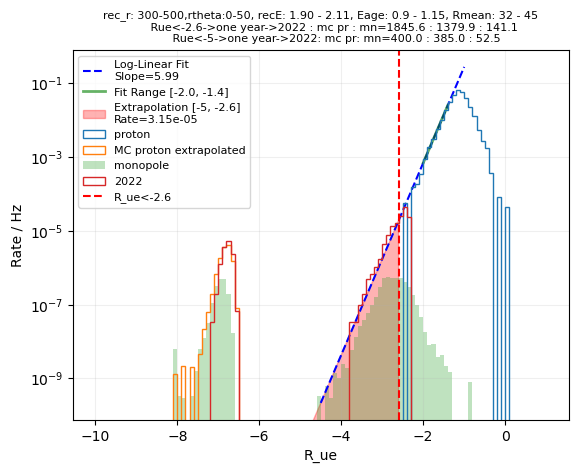

In [144]:
def NuM1_fit_landau_integrated(proton_df_age_infit, bins=300, ranges=[0, 300]):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.optimize import curve_fit
    from scipy.stats import moyal
    from scipy.integrate import quad # <--- 引入积分函数

   
    hist_y, bin_edges = np.histogram(
        proton_df_age_infit["NuM1"], 
        bins=bins, 
        range=ranges, 
        weights=proton_df_age_infit["weight"]
    )
    
    # 算出 bin 宽度
    bin_width = (ranges[1] - ranges[0]) / bins
    
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # 筛选拟合数据
    mask = hist_y > 0
    x_fit = bin_centers[mask]
    y_fit = hist_y[mask]
    sigma_fit = np.sqrt(y_fit)
    sigma_fit[sigma_fit == 0] = 1e-10

    # 2. 定义函数 (Moyal/Landau)
    # 注意：这里的 amplitude 实际上是“总面积”的一个缩放因子，因为 pdf 积分是 1
    # 如果 hist_y 是 Rate，那么 amplitude 大概就是总 Rate
    def landau_func(x, amplitude, mpv, width):
        return amplitude * moyal.pdf(x, loc=mpv, scale=width)

    # 3. 拟合
    # 改进初始猜测
    p0 = [np.sum(y_fit)*bin_width, x_fit[np.argmax(y_fit)], 10.0] 
    bounds = ([0, 0, 0.1], [np.inf, 300, 100])

    try:
        popt, pcov = curve_fit(landau_func, x_fit, y_fit, p0=p0, sigma=sigma_fit, absolute_sigma=True, bounds=bounds)
        fit_success = True
        print(f"拟合参数: Amp={popt[0]:.2e}, MPV={popt[1]:.2f}, Width={popt[2]:.2f}")
    except Exception as e:
        print(f"拟合失败: {e}")
        fit_success = False
        popt = [0, 0, 0]

    # ======================================================
    # 4. 关键步骤：积分计算 NuM1 在 [0, 1] 区间的 Rate
    # ======================================================
    if fit_success:
        # 定义被积函数 (即我们拟合出来的函数)
        def fitted_curve(x):
            return landau_func(x, *popt)
        
        # 对 0 到 1 进行积分
        # 这里的 1 实际上是 bin_width。如果你的第一格是 0-1，就积 0-1。
        rate_integrated, error = quad(fitted_curve, 0, 1)
        
        print(f"========================================")
        print(f"直接取函数值 f(0):       {fitted_curve(0):.4e}")
        print(f"积分区间 [0, 1] 的 Rate: {rate_integrated:.4e} Hz")
        print(f"========================================")
    else:
        rate_integrated = 0

    # 5. 绘图
    plt.hist(proton_df_age_infit["NuM1"], bins=bins, range=ranges,
             histtype='step', weights=proton_df_age_infit["weight"],
             label="Proton Data", color='black')

    if fit_success:
        x_plot = np.linspace(ranges[0],ranges[1], 1000)
        plt.plot(x_plot, landau_func(x_plot, *popt), 'r-', label="Landau Fit")
        
        # 画出我们积分的那个小区域 (0-1)
        x_area = np.linspace(0, 1, 50)
        plt.fill_between(x_area, landau_func(x_area, *popt), color='red', alpha=0.5, label="Integral Region [0-1]")

    plt.xlabel("NuM1")
    plt.ylabel("Rate / Hz")
    plt.legend()
    plt.yscale('log') # 推荐打开 log 看 0 处的细节
    # plt.show()
    plt.close()

    return rate_integrated

num_0=NuM1_fit_landau_integrated(pr_df_Rmean, bins=200, ranges=[0,200])
print(f"one year : {num_0*365*86400}")

pr_df_Rmean_cp=pr_df_Rmean.copy()
pr_df_Rmean_cp['NuM1']=0
pr_df_Rmean_cp["R_ue"]=np.log10((1e-4 + 0)/pr_df_Rmean_cp['NpE3'])
weight_scale=num_0/np.sum(pr_df_Rmean['weight'])

fit_min = -2.0
fit_max = -1.4
target_low = -5
target_high = -2.6

def fit_log_linear_and_integrate(df, col_name='R_ue', weight_col='weight'):
    # ==========================================
    # 1. 准备直方图数据
    # ==========================================
    # 扩大范围以覆盖拟合区和外推区
    ranges = [-5, 1] 
    bins = 60  # 保持足够的分辨率
    
    data = df[col_name]
    weights = df[weight_col]

    # 获取直方图内容
    hist_y, bin_edges = np.histogram(data, bins=bins, range=ranges, weights=weights)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # ==========================================
    # 2. 筛选拟合区域 [-2.4, -1.2]
    # ==========================================
    
    
    # 掩膜条件：在范围内 且 计数 > 0 (因为要取对数)
    mask = (bin_centers >= fit_min) & (bin_centers <= fit_max) & (hist_y > 0)
    
    x_fit = bin_centers[mask]
    y_fit = hist_y[mask]
    
    # 取对数 (这里用自然对数 ln，计算积分更方便)
    log_y_fit = np.log(y_fit)

    # ==========================================
    # 3. 线性拟合 (在 Log 空间)
    # ==========================================
    # 拟合模型: ln(y) = slope * x + intercept
    if len(x_fit) > 1:
        slope, intercept = np.polyfit(x_fit, log_y_fit, 1)
        fit_success = True
        print(f"拟合成功: ln(y) = {slope:.4f} * x + {intercept:.4f}")
    else:
        print("错误: 拟合区间内有效数据点不足")
        fit_success = False
        slope, intercept = 0, 0

    
    
    bin_width = (ranges[1] - ranges[0]) / bins  # 修正点1
    
    rate_integrated = 0
    if fit_success:
        # 积分公式: integral(e^(kx+b)) = (1/k) * [e^(kx+b)]
        def anti_derivative(x):
            return (1.0 / slope) * np.exp(slope * x + intercept)
        
        # 计算数学积分 (面积)
        area_under_curve = anti_derivative(target_high) - anti_derivative(target_low)
        
        # 修正点2：将面积转换为计数 (Rate)
        rate_integrated = area_under_curve / bin_width
        
        print(f"========================================")
        print(f"Bin Width: {bin_width:.4f}")
        print(f"拟合斜率 (Slope): {slope:.4f}")
        print(f"数学积分 (Area): {area_under_curve:.4e}")
        print(f"修正后的推断 Rate (Sum of Weights): {rate_integrated:.4e} Hz")
        print(f"========================================")

    if fit_success:
        # B. 画拟合线 (延伸覆盖拟合区和外推区)
        x_plot = np.linspace(-4.5, -1.0, 200)
        # y = exp(slope * x + intercept)
        y_plot = np.exp(slope * x_plot + intercept)
        
       
        plt.plot(x_plot, y_plot, 'b--', label=f'Log-Linear Fit\nSlope={slope:.2f}')
        
        # C. 标记拟合采用的区间 (用不同颜色线段或者加粗)
        x_fit_region = np.linspace(fit_min, fit_max, 50)
        y_fit_region = np.exp(slope * x_fit_region + intercept)
        plt.plot(x_fit_region, y_fit_region, 'g-', linewidth=2, alpha=0.6, label=f'Fit Range [{fit_min}, {fit_max}]')

        # D. 填充积分区域 (目标区域)
        x_fill = np.linspace(target_low, target_high, 100)
        y_fill = np.exp(slope * x_fill + intercept)
        plt.fill_between(x_fill, y_fill, color='red', alpha=0.3, 
                         label=f'Extrapolation [{target_low}, {target_high}]\nRate={rate_integrated:.2e}')
    ranges=(-10,1)
    bins=int(ranges[1]-ranges[0])*10
    R_ue_cut=target_high
    pr_extr_num=rate_integrated+np.sum(pr_df_Rmean_cp['weight'])*weight_scale if R_ue_cut>target_low else np.sum(pr_df_Rmean_cp['weight'])*weight_scale
    # pr_extr_num=np.sum(pr_df_age_cp['weight'])*weight_scale 
    print(f"one year: mc pr : {np.sum(pr_df_Rmean_cp['weight'])*weight_scale *86400*365:.1f}+{rate_integrated*86400*365:.1f}={pr_extr_num*86400*365:.1f}")
    mn_num_Rue_cut=np.sum(mn_df_Rmean[mn_df_Rmean['R_ue']<R_ue_cut]['weight'].values)
    mn_num_no_mu=np.sum(mn_df_Rmean[mn_df_Rmean['R_ue']<-5]['weight'].values)
    df_2022_num_no_muon=np.sum(df_recE_age[df_recE_age['R_ue']<-5]['weight'].values)
    df_2022_num=np.sum(df_recE_age[df_recE_age['R_ue']<R_ue_cut]['weight'].values)
    time=86400*365
    plt.hist(pr_df_Rmean['R_ue'], bins=bins,histtype='step',weights=pr_df_Rmean['weight'],range=ranges, label='proton')
    plt.hist(pr_df_Rmean_cp['R_ue'], bins=bins,histtype='step',weights=pr_df_Rmean_cp['weight']*weight_scale,range=ranges, label='MC proton extrapolated')
    plt.hist(mn_df_Rmean['R_ue'],bins=bins,histtype='stepfilled',weights=mn_df_Rmean['weight'],range=ranges,alpha=0.3,label='monopole')
    plt.hist(df_recE_age['R_ue'],bins=bins,histtype='step',weights=df_recE_age['weight'],range=ranges, label='2022')
    plt.axvline(x=R_ue_cut,color='r',linestyle='--', label=f"R_ue<{R_ue_cut}")
    plt.yscale('log')
    plt.ylabel('Rate / Hz')
    plt.xlabel('R_ue')
    plt.title(f"rec_r: {r_cut_low}-{r_cut_high},rtheta:{theta_cut_low}-{theta_cut_high}, recE: {log10TeV_low:.2f} - {log10TeV_high:.2f}, Eage: {age_low} - {age_high}, Rmean: {R_mean_low} - {R_mean_high}\n \
        Rue<{R_ue_cut}->one year->2022 : mc pr : mn={df_2022_num*time:.1f} : {pr_extr_num*time:.1f} : {mn_num_Rue_cut*time:.1f} \n \
        Rue<{-5}->one year->2022: mc pr: mn={df_2022_num_no_muon*time:.1f} : {np.sum(pr_df_Rmean_cp['weight'])*weight_scale*time:.1f} : {mn_num_no_mu*time:.1f}", fontsize=8)
    plt.legend(fontsize=8,loc='best')
    plt.grid(True, which="both", ls="-", alpha=0.2)
    # plt.xlim(-4.5, 0.5) # 聚焦关注区域
    # plt.ylim(1e-5, 1) # 根据实际数据调整
    plt.savefig(f"./figures/R_ue_extrapolation.png", dpi=300)
    plt.show()

# 调用函数
fit_log_linear_and_integrate(pr_df_Rmean)





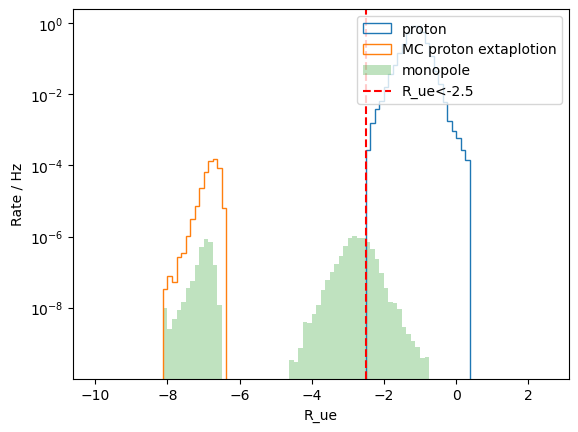

拟合参数: Amp=3.77e+00, MPV=33.34, Width=12.56
直接取函数值 f(0):       3.6943e-04 (不推荐)
积分区间 [0, 1] 的 Rate: 4.8214e-04 Hz (推荐)


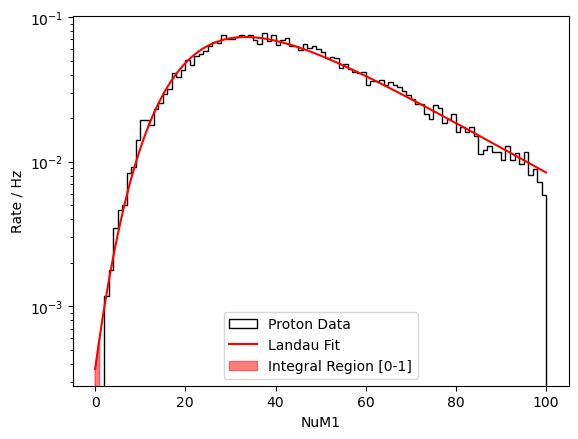

In [195]:
# plt.hist(pr_df['recE'],bins=100,histtype='step',weights=pr_df['weight'],label='proton')
# plt.hist(mn_df['recE'],bins=100,histtype='stepfilled',weights=mn_df['weight'],alpha=0.3,label='monopole')
# plt.yscale('log')
# plt.ylabel('Rate / Hz')
# plt.xlabel('log10(recE/TeV)')
# plt.legend(loc='upper right')
# plt.show()






# plt.hist(pr_df['Eage'],bins=100,histtype='step',weights=pr_df['weight'],label='proton')
# plt.hist(mn_df['Eage'],bins=100,histtype='stepfilled',weights=mn_df['weight'],alpha=0.3,label='monopole')
# plt.axvline(x=age_low,color='r',linestyle='--', label=f"{age_low}<Eage<{age_high}")
# plt.axvline(x=age_high,color='r',linestyle='--')
# plt.yscale('log')
# plt.ylabel('Rate / Hz')
# plt.xlabel('Eage')
# plt.legend(loc='upper right')
# plt.show()

# plt.hist(pr_df_age['R_mean'],bins=100,histtype='step',weights=pr_df_age['weight'],label='proton')
# plt.hist(mn_df_age['R_mean'],bins=100,histtype='stepfilled',weights=mn_df_age['weight'],alpha=0.3,label='monopole')
# plt.axvline(x=R_mean_low,color='r',linestyle='--', label=f"{R_mean_low}<R_mean<{R_mean_high}")
# plt.axvline(x=R_mean_high,color='r',linestyle='--')
# plt.yscale('log')
# plt.ylabel('Rate / Hz')
# plt.xlabel('R_mean')
# plt.legend(loc='upper right')
# plt.show()





# pr_df_Rue= pr_df_Rmean[(pr_df_Rmean['R_ue']<R_ue_cut)]
# mn_df_Rue = mn_df_Rmean[(mn_df_Rmean['R_ue']<R_ue_cut)]

# print(f"When age:{age_low}~{age_high}:")
# print(f"Proton: {np.sum(pr_df_age['weight'])}, left ratio: {np.sum(pr_df_age['weight'])/np.sum(pr_df['weight']):.2e}")
# print(f"Monopole: {np.sum(mn_df_age['weight'])}, left ratio: {np.sum(mn_df_age['weight'])/np.sum(mn_df['weight']):.2e}")
# print()
# print(f"When R_mean:{R_mean_low}~{R_mean_high}:")
# print(f"Proton: {np.sum(pr_df_Rmean['weight'])}, left ratio: {np.sum(pr_df_Rmean['weight'])/np.sum(pr_df_age['weight']):.2e}")
# print(f"Monopole: {np.sum(mn_df_Rmean['weight'])}, left ratio: {np.sum(mn_df_Rmean['weight'])/np.sum(mn_df_age['weight']):.2e}")
# print()
# print(f"When R_ue<{R_ue_cut}:")
# print(f"Proton: {np.sum(pr_df_Rue['weight'])}, left ratio: {np.sum(pr_df_Rue['weight'])/np.sum(pr_df_Rmean['weight']):.2e}")
# print(f"Monopole: {np.sum(mn_df_Rue['weight'])}, left ratio: {np.sum(mn_df_Rue['weight'])/np.sum(mn_df_Rmean['weight']):.2e}")
# print()
# print(f"Proton:Monopole= {np.sum(pr_df_Rue['weight'])/np.sum(mn_df_Rue['weight']):.2e}:1")


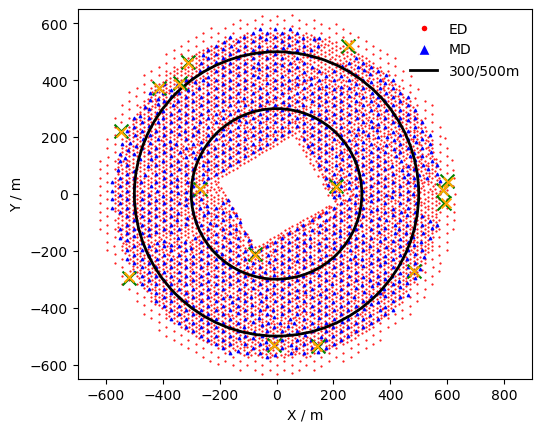

In [60]:

# 去掉第一行,然后给cols=id ,x,y,z   
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
ED_pos=pd.read_csv("/home/zhonghua/Filt_Event/config/ED_all.txt",header=None,names=["id","x","y","z"], skiprows=2,  sep=r'\s+', )
MD_pos=pd.read_csv("/home/zhonghua/Filt_Event/config/MD_all.txt",header=None,names=["id","x","y","z"], skiprows=2,  sep=r'\s+', )
plt.scatter(ED_pos["x"],ED_pos["y"],marker="o", s=0.3, c="red", label="ED")
plt.scatter(MD_pos["x"],MD_pos["y"],marker="^",  s=3, c="blue", label="MD")
circle = plt.Circle((0, 0), 500, color='black', fill=False, linewidth=2, label='500m')
circle2 = plt.Circle((0, 0), 300, color='black', fill=False, linewidth=2, label='300m')
plt.gca().add_patch(circle)
plt.gca().add_patch(circle2)
plt.gca().set_aspect('equal') 
plt.xlim(-700,900)
plt.ylim(-650,650)
plt.xlabel("X / m")
plt.ylabel("Y / m")
plt.scatter(pr_df_Rue["rec_x"],pr_df_Rue["rec_y"],marker="x", s=100, c="green", label='proton')
plt.scatter(-pr_df_Rue["core_y"],pr_df_Rue["core_x"],marker="x", s=50, c="orange",)
# plt.scatter(mn_df_Rue["rec_x"],mn_df_Rue["rec_y"],marker="x", s=20, c="green", label='monopole')


from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='ED',
           markerfacecolor='red', markersize=5),
    Line2D([0], [0], marker='^', color='w', label='MD',
           markerfacecolor='blue', markersize=8),
    Line2D([0], [0], color='black', lw=2, label='300/500m'),


]
plt.legend(handles=legend_elements, loc='upper right', frameon=False)
plt.show()



In [187]:
# 实验数据
# /home/zhonghua/data/Dataset_Filted/Experiment/2022/2022_merged_Rue_3.3.root
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import uproot

def NuM1_fit_landau_integrated(proton_df_age_infit, bins=300, ranges=[0, 300]):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.optimize import curve_fit
    from scipy.stats import moyal
    from scipy.integrate import quad # <--- 引入积分函数

   
    hist_y, bin_edges = np.histogram(
        proton_df_age_infit["NuM1"], 
        bins=bins, 
        range=ranges, 
        weights=proton_df_age_infit["weight"]
    )
    
    # 算出 bin 宽度
    bin_width = (ranges[1] - ranges[0]) / bins
    
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # 筛选拟合数据
    mask = hist_y > 0
    x_fit = bin_centers[mask]
    y_fit = hist_y[mask]
    sigma_fit = np.sqrt(y_fit)
    sigma_fit[sigma_fit == 0] = 1e-10

    # 2. 定义函数 (Moyal/Landau)
    # 注意：这里的 amplitude 实际上是“总面积”的一个缩放因子，因为 pdf 积分是 1
    # 如果 hist_y 是 Rate，那么 amplitude 大概就是总 Rate
    def landau_func(x, amplitude, mpv, width):
        return amplitude * moyal.pdf(x, loc=mpv, scale=width)

    # 3. 拟合
    # 改进初始猜测
    p0 = [np.sum(y_fit)*bin_width, x_fit[np.argmax(y_fit)], 10.0] 
    bounds = ([0, 0, 0.1], [np.inf, 300, 100])

    try:
        popt, pcov = curve_fit(landau_func, x_fit, y_fit, p0=p0, sigma=sigma_fit, absolute_sigma=True, bounds=bounds)
        fit_success = True
        print(f"拟合参数: Amp={popt[0]:.2e}, MPV={popt[1]:.2f}, Width={popt[2]:.2f}")
    except Exception as e:
        print(f"拟合失败: {e}")
        fit_success = False
        popt = [0, 0, 0]

    # ======================================================
    # 4. 关键步骤：积分计算 NuM1 在 [0, 1] 区间的 Rate
    # ======================================================
    if fit_success:
        # 定义被积函数 (即我们拟合出来的函数)
        def fitted_curve(x):
            return landau_func(x, *popt)
        
        # 对 0 到 1 进行积分
        # 这里的 1 实际上是 bin_width。如果你的第一格是 0-1，就积 0-1。
        rate_integrated, error = quad(fitted_curve, 0, 1)
        
        print(f"========================================")
        print(f"直接取函数值 f(0):       {fitted_curve(0):.4e} (不推荐)")
        print(f"积分区间 [0, 1] 的 Rate: {rate_integrated:.4e} Hz (推荐)")
        print(f"========================================")
    else:
        rate_integrated = 0

    # 5. 绘图
    plt.hist(proton_df_age_infit["NuM1"], bins=bins, range=ranges,
             histtype='step', weights=proton_df_age_infit["weight"],
             label="Proton Data", color='black')

    if fit_success:
        x_plot = np.linspace(ranges[0],ranges[1], 1000)
        plt.plot(x_plot, landau_func(x_plot, *popt), 'r-', label="Landau Fit")
        
        # 画出我们积分的那个小区域 (0-1)
        x_area = np.linspace(0, 1, 50)
        plt.fill_between(x_area, landau_func(x_area, *popt), color='red', alpha=0.5, label="Integral Region [0-1]")

    plt.xlabel("NuM1")
    plt.ylabel("Rate / Hz")
    plt.legend()
    plt.yscale('log') # 推荐打开 log 看 0 处的细节
    plt.show()



2022 age >0.8 and age<1.1: left ratio : 0.2481508875739645
mn age >0.8 and age<1.1: left ratio : 0.6980035475714231
pr age >0.8 and age<1.1: left ratio : 0.21420423548083123
2022 recE >1.95: left ratio : 0.1717585692995529
mn recE >1.95: left ratio : 0.7375506893755069
pr recE >1.95: left ratio : 0.45010419078490393
2022 recE >1.95 and rec_r >300 and rec_r <500: left ratio : 0.527114967462039
拟合参数: Amp=2.92e-01, MPV=40.96, Width=14.67
直接取函数值 f(0):       9.2259e-06 (不推荐)
积分区间 [0, 1] 的 Rate: 1.2026e-05 Hz (推荐)


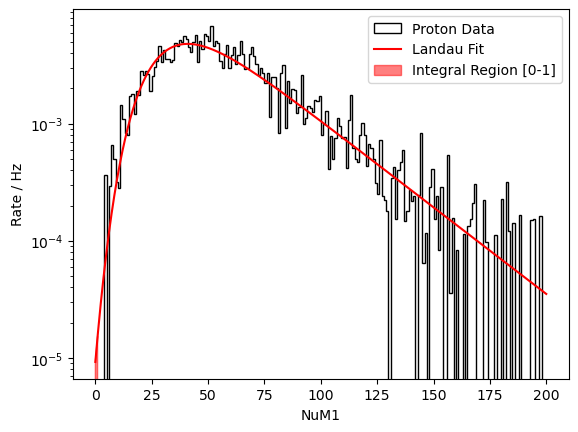

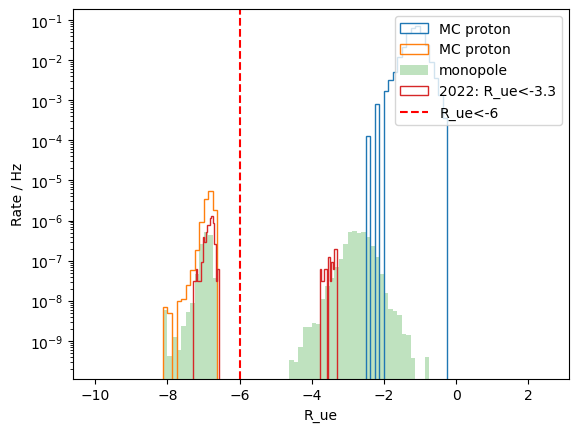

when R_ue<-6: 
2022: 213 events / year. 6.754185692541858e-06 events / second
Monopole: 41.24662984177753 events / year. 1.3079220523141024e-06 events / second
2022 : Monopole: 5.16405827135623 : 1
MN 0.5183409746077724


In [188]:
# plt.hist(df_2022["R_ue"], bins=100,density=False, histtype='step', label='2022')
# plt.show()
# plt.hist(df_2022['rec_r'], bins=100,density=False, histtype='step', label='2022')
# plt.show()
# plt.hist(df_2022['recE'], bins=100,density=False,  weights=np.ones(len(df_2022))/365/86400, histtype='step', label='2022')
# plt.hist(mn_df_Rmean['recE'],bins=100,histtype='stepfilled',weights=mn_df_Rmean['weight'],alpha=0.3,label='monopole')
# plt.yscale('log')
# plt.xlabel('recE')
# plt.ylabel('counts')
# plt.legend()
# plt.show()
# # age
# plt.hist(df_2022['age'], bins=100,density=False,  weights=np.ones(len(df_2022))/365/86400, histtype='step', label='2022')
# plt.hist(mn_df_Rmean['Eage'],bins=100,histtype='stepfilled',weights=mn_df_Rmean['weight'],alpha=0.3,label='monopole')
# plt.yscale('log')
# plt.xlabel('age')
# plt.ylabel('counts')
# plt.legend()
# plt.show()
# plt.hist(df_2022['r_Theta']*180/np.pi, bins=100,density=False, histtype='step', label='2022')
# plt.show()
age_cut_low=0.8
age_cut_high=1.1

recE_cut = 1.95
R_ue_cut=-6

df_2022_age_cut=df_2022[(df_2022['age']<age_cut_high) & (df_2022['age']>age_cut_low)]
mn_df_Rmean_age=mn_df_Rmean[(mn_df_Rmean['Eage']<age_cut_high) & (mn_df_Rmean['Eage']>age_cut_low)]
pr_df_Rmean_age=pr_df_Rmean[(pr_df_Rmean['Eage']<age_cut_high) & (pr_df_Rmean['Eage']>age_cut_low)]
print(f"2022 age >{age_cut_low} and age<{age_cut_high}: left ratio : {len(df_2022_age_cut)/len(df_2022)}")
print(f"mn age >{age_cut_low} and age<{age_cut_high}: left ratio : {len(mn_df_Rmean_age)/len(mn_df_Rmean)}")
print(f"pr age >{age_cut_low} and age<{age_cut_high}: left ratio : {len(pr_df_Rmean_age)/len(pr_df_Rmean)}")
df_2022_recE=df_2022_age_cut[df_2022_age_cut["recE"]>recE_cut]
mn_df_Rmean_recE=mn_df_Rmean_age[mn_df_Rmean_age['recE']>recE_cut]
pr_df_Rmean_recE=pr_df_Rmean_age[pr_df_Rmean_age['recE']>recE_cut]
print(f"2022 recE >{recE_cut}: left ratio : {len(df_2022_recE)/len(df_2022_age_cut)}")
print(f"mn recE >{recE_cut}: left ratio : {len(mn_df_Rmean_recE)/len(mn_df_Rmean_age)}")
print(f"pr recE >{recE_cut}: left ratio : {len(pr_df_Rmean_recE)/len(pr_df_Rmean_age)}")
df_r_cut_recE=df_2022_recE[(df_2022_recE['rec_r']<500) & (df_2022_recE['rec_r']>300) ]
print(f"2022 recE >{recE_cut} and rec_r >300 and rec_r <500: left ratio : {len(df_r_cut_recE)/len(df_2022_recE)}")

NuM1_fit_landau_integrated(pr_df_Rmean_recE, bins=200, ranges=[0,200])

pr_df_Rmean_recE_cp=pr_df_Rmean_recE.copy()
pr_df_Rmean_recE_cp['NuM1']=0
pr_df_Rmean_recE_cp["R_ue"]=np.log10((1e-4 + 0)/pr_df_Rmean_recE_cp['NpE3'])
weight_scale=1.2026e-05/np.sum(pr_df_Rmean_recE['weight'])

ranges=[-10,2.5]
plt.hist(pr_df_Rmean_recE['R_ue'], bins=100,histtype='step',weights=pr_df_Rmean_recE['weight'],range=ranges, label='MC proton')
plt.hist(pr_df_Rmean_recE_cp['R_ue'], bins=100,histtype='step',weights=pr_df_Rmean_recE_cp['weight']*weight_scale,range=ranges, label='MC proton')
plt.hist(mn_df_Rmean_recE['R_ue'],bins=100,histtype='stepfilled',weights=mn_df_Rmean_recE['weight'],range=ranges,alpha=0.3,label='monopole')
plt.hist(df_r_cut_recE['R_ue'], bins=100,density=False, weights=np.ones(len(df_r_cut_recE))/365/86400, histtype='step', label='2022: R_ue<-3.3')
plt.axvline(x=R_ue_cut,color='r',linestyle='--', label=f"R_ue<{R_ue_cut}")
plt.yscale('log')
plt.ylabel('Rate / Hz')
plt.xlabel('R_ue')
plt.legend(loc='upper right')
plt.show()

# 统计R_ue_cut后的
R_ue_cut=-6
df_2022_R_ue_cut_recE = df_r_cut_recE[df_r_cut_recE['R_ue']<R_ue_cut]
mn_df_R_ue_cut_recE = mn_df_Rmean_recE[mn_df_Rmean_recE['R_ue']<R_ue_cut]

print(f"when R_ue<{R_ue_cut}: ")
print(f"2022: {len(df_2022_R_ue_cut_recE)} events / year. {len(df_2022_R_ue_cut_recE)/365/86400} events / second")
print(f"Monopole: {np.sum(mn_df_R_ue_cut_recE['weight'])*86400*365} events / year. {np.sum(mn_df_R_ue_cut_recE['weight'])} events / second")
print(f"2022 : Monopole: {len(df_2022_R_ue_cut_recE)/86400/365/np.sum(mn_df_R_ue_cut_recE['weight'])} : 1")
print(f"MN {mn_df_Rmean_recE['weight'].sum()/np.sum(mn_df['weight'].values)}")


In [65]:
ns=[]
for i, value in enumerate(values):
    area=np.pi*1000**2*np.cos(np.deg2rad(centers[i]))
    num=value*area
    ns.append(num)
acceptance=np.sum(ns)*(4627/251000)*(0.95*0.99*0.403)/86400
times=86400*365
ul=2.44/(acceptance)*1e-4/times
print(ul)
print()
acceptance=np.sum(ns)*(26611/251000)*(0.996*0.829)/86400
times=86400*365*1
ul=2.44/(acceptance)*1e-4/times
print(ul)
acceptance=np.sum(ns)*(26611/251000)*(0.51)/86400
times=86400*365*1
ul=2.44/(acceptance)*1e-4/times
print(ul)

acceptance=np.sum(ns)*(26611*4/251000)*(0.996*0.829)/86400
times=86400*365*5
ul=2.44/(acceptance)*1e-4/times
print(ul)


1.706017802125584e-16

1.3616699089709958e-17
2.2045275629780545e-17
6.808349544854979e-19


In [46]:
import numpy as np

# 你的数据
particle_data = {
    'Proton': {'total_weight': 18.191804394738597, 'ratios': [0.55334985, 0.25449584, 0.11648485, 0.05251553, 0.02315394]},
    'He': {'total_weight': 21.868503294026596, 'ratios': [0.53475009, 0.2563261, 0.12294294, 0.05850706, 0.02747381]},
    'CNO': {'total_weight': 7.918033157663814, 'ratios': [0.53738941, 0.25583956, 0.12158647, 0.05779985, 0.02738471]},
    'Fe': {'total_weight': 7.681388695879583, 'ratios': [0.53581289, 0.25596968, 0.12208392, 0.0583358, 0.02779771]},
    'MgAlSi': {'total_weight': 3.6464848740111506, 'ratios': [0.53757339, 0.25531695, 0.12153546, 0.05790292, 0.02767129]}
}

total_events = 100000

# 计算总权重
total_weight = sum(data['total_weight'] for data in particle_data.values())
print(f"总权重: {total_weight}")

# 计算每个粒子的比例
particle_ratios = {}
for particle, data in particle_data.items():
    particle_ratios[particle] = data['total_weight'] / total_weight

print("\n各粒子总体比例:")
for particle, ratio in particle_ratios.items():
    print(f"{particle}: {ratio:.3%}")

# 计算每个粒子在每个能量区间的目标事件数
print(f"\n目标总事件数: {total_events:,}")
print("=" * 60)

for particle, data in particle_data.items():
    particle_total = total_events * particle_ratios[particle]
    print(f"\n{particle}:")
    print(f"  总事件数: {particle_total:.0f}")
    
    for i, ratio in enumerate(data['ratios']):
        bin_events = particle_total * ratio
        print(f"  能量区间 {i+1}: {bin_events:.0f} 事件 (比例: {ratio:.2%})")


总权重: 59.30621441631974

各粒子总体比例:
Proton: 30.674%
He: 36.874%
CNO: 13.351%
Fe: 12.952%
MgAlSi: 6.149%

目标总事件数: 100,000

Proton:
  总事件数: 30674
  能量区间 1: 16974 事件 (比例: 55.33%)
  能量区间 2: 7806 事件 (比例: 25.45%)
  能量区间 3: 3573 事件 (比例: 11.65%)
  能量区间 4: 1611 事件 (比例: 5.25%)
  能量区间 5: 710 事件 (比例: 2.32%)

He:
  总事件数: 36874
  能量区间 1: 19718 事件 (比例: 53.48%)
  能量区间 2: 9452 事件 (比例: 25.63%)
  能量区间 3: 4533 事件 (比例: 12.29%)
  能量区间 4: 2157 事件 (比例: 5.85%)
  能量区间 5: 1013 事件 (比例: 2.75%)

CNO:
  总事件数: 13351
  能量区间 1: 7175 事件 (比例: 53.74%)
  能量区间 2: 3416 事件 (比例: 25.58%)
  能量区间 3: 1623 事件 (比例: 12.16%)
  能量区间 4: 772 事件 (比例: 5.78%)
  能量区间 5: 366 事件 (比例: 2.74%)

Fe:
  总事件数: 12952
  能量区间 1: 6940 事件 (比例: 53.58%)
  能量区间 2: 3315 事件 (比例: 25.60%)
  能量区间 3: 1581 事件 (比例: 12.21%)
  能量区间 4: 756 事件 (比例: 5.83%)
  能量区间 5: 360 事件 (比例: 2.78%)

MgAlSi:
  总事件数: 6149
  能量区间 1: 3305 事件 (比例: 53.76%)
  能量区间 2: 1570 事件 (比例: 25.53%)
  能量区间 3: 747 事件 (比例: 12.15%)
  能量区间 4: 356 事件 (比例: 5.79%)
  能量区间 5: 170 事件 (比例: 2.77%)


In [45]:
for i in range(55,65):
    print(f"run_start={1000+i*10+1}")
    print(f"run_end={1000+i*10+10}")
    print()


run_start=1551
run_end=1560

run_start=1561
run_end=1570

run_start=1571
run_end=1580

run_start=1581
run_end=1590

run_start=1591
run_end=1600

run_start=1601
run_end=1610

run_start=1611
run_end=1620

run_start=1621
run_end=1630

run_start=1631
run_end=1640

run_start=1641
run_end=1650



In [ ]:
np.log10((1e-4 +1)/3000)

40.5/np.sqrt(205)


8.94495361206257